In [ ]:
# %%capture
# !pip install scipy statsmodels matplotlib seaborn matplotlib-venn nltk networkx pyvis

Link para v√≠deo: https://www.youtube.com/watch?v=xKbhL2E6kuI&ab_channel=GuiSales

In [82]:
import re
import pandas as pd
import numpy as np
from scipy import stats
import warnings
from statsmodels.stats.diagnostic import normal_ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib_venn import venn3
import matplotlib.dates as mdates
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
import networkx as nx
from pyvis.network import Network
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### a) Ler o dataset fakeTelegram.BR_2022.csv

In [3]:
df = pd.read_csv('../Atividade 2/fakeTelegram.BR_2022.csv')

### b) Remova os trava-zaps.

In [4]:
len(df.index)

557586

In [5]:
df = df.loc[df['trava_zap'] == False]

In [6]:
len(df.index)

557570

### c) Remover as linhas repetidas (duplicadas).

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
len(df.index)

557570

In [9]:
df_teste = df.drop_duplicates(subset=[col for col in df.columns if col != 'data_system' or col != 'date_message' or col!='text_content_anonymous'])
len(df_teste.index)

557570

### d) Remover textos com menos de 5 palavras.

In [10]:
df = df.loc[df['text_content_anonymous'].isna() == False]
df.reset_index(inplace=True, drop=True)

In [11]:
len(df.index)

444201

In [12]:
df.drop([i for i, s in enumerate(df['text_content_anonymous'].values.tolist()) if len(s.split()) < 5 ], inplace=True)

In [13]:
len(df.index)

339286

Adicionando coluna com quantidade de palavras

In [14]:
df['word_count'] = df['text_content_anonymous'].str.split().str.len()

### e) Para cada atributo num√©rico apresente:
	 	1. Medidas de Tend√™ncia Central
	 	2. Medidas de Variabilidade
	 	3. Tabela de Frequ√™ncia e Histograma
	 	4. Boxplot
	 	5. QQ-Plot
	 	6. Teste de Normalidade
	 	7. Best Fit Distribution (usando diferentes m√©todos)

In [15]:
# Subitens 1 e 2
def centralidade_variabilidade(valores):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]
    
    print("=== Medidas de Tend√™ncia Central ===")
    print(f"M√©dia: {np.mean(valores):.4f}")
    print(f"Mediana: {np.median(valores):.4f}")
    moda = stats.mode(valores, keepdims=True)
    print(f"Moda: {moda.mode[0]} (Frequ√™ncia: {moda.count[0]})")
    
    print("\n=== Medidas de Variabilidade ===")
    print(f"Amplitude: {np.ptp(valores):.4f}")
    print(f"Desvio Padr√£o: {np.std(valores, ddof=1):.4f}")
    print(f"Vari√¢ncia: {np.var(valores, ddof=1):.4f}")
    print(f"Coeficiente de Varia√ß√£o (CV): {100 * np.std(valores, ddof=1) / np.mean(valores):.2f}%")
    q75, q25 = np.percentile(valores, [75 ,25])
    print(f"IQR (Intervalo Interquart√≠lico): {q75 - q25:.4f}")


In [ ]:
#Subitens 3, 4 e 5
def plotar_diagnosticos_distribuicao(valores, bins=10):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]

    # === Tabela de Frequ√™ncia ===
    print("=== Tabela de Frequ√™ncia ===")
    contagem, intervalos = np.histogram(valores, bins=bins)
    porcentagens = 100 * contagem / contagem.sum()
    linhas = []

    for i in range(len(contagem)):
        linhas.append({
            'Intervalo': f"[{intervalos[i]:.2f}, {intervalos[i+1]:.2f})",
            'Frequ√™ncia': contagem[i],
            'Percentual (%)': f"{porcentagens[i]:.2f}"
        })

    tabela = pd.DataFrame(linhas)
    print(tabela.to_string(index=False))

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Boxplot
    axs[0].boxplot(valores, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[0].set_title('Boxplot')
    axs[0].grid(True)

    # Q-Q Plot
    stats.probplot(valores, dist="norm", plot=axs[1])
    axs[1].get_lines()[1].set_color('red')
    axs[1].set_title('Q-Q Plot (Normal)')

    # Histograma com curva normal
    mu, sigma = np.mean(valores), np.std(valores, ddof=1)
    axs[2].hist(valores, bins=bins, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    x = np.linspace(min(valores), max(valores), 1000)
    normal_pdf = stats.norm.pdf(x, mu, sigma)
    axs[2].plot(x, normal_pdf, 'r-', linewidth=2, label='Curva Normal')
    axs[2].set_title('Histograma com Curva Normal')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


In [17]:
# Subitem 6
def normalidade(valores):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]

    print("=== Testes de Normalidade ===")

    # Shapiro-Wilk
    stat_shapiro, p_shapiro = stats.shapiro(valores)
    print(f"Shapiro-Wilk: Estat√≠stica = {stat_shapiro:.4f}, p-valor = {p_shapiro:.4f} -> {'Normal' if p_shapiro > 0.05 else 'N√£o Normal'}")

    # Anderson-Darling
    stat_ad, p_value_ad = normal_ad(valores)
    print(f"Anderson-Darling: Estat√≠stica = {stat_ad:.4f}, p-valor = {p_value_ad:.4f} -> {'Normal' if p_value_ad > 0.05 else 'N√£o Normal'}")

    # Kolmogorov-Smirnov (ajustado com m√©dia e std da amostra)
    mu, sigma = np.mean(valores), np.std(valores, ddof=1)
    ks_stat, ks_p = stats.kstest(valores, 'norm', args=(mu, sigma))
    print(f"Kolmogorov-Smirnov: Estat√≠stica = {ks_stat:.4f}, p-valor = {ks_p:.4f} -> {'Normal' if ks_p > 0.05 else 'N√£o Normal'}")

In [18]:
#subitem 7
def best_fit_distribution(valores, verbose=True):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]

    DISTRIBUICOES_TESTADAS = [
        stats.norm, stats.expon, stats.gamma, stats.beta,
        stats.lognorm, stats.weibull_min, stats.weibull_max,
        stats.uniform, stats.pareto
    ]

    resultados = []

    for dist in DISTRIBUICOES_TESTADAS:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                params = dist.fit(valores)

                log_likelihood = np.sum(dist.logpdf(valores, *params))

                k = len(params)

                aic = 2 * k - 2 * log_likelihood

                ks_stat, ks_p = stats.kstest(valores, dist.name, args=params)

                resultados.append({
                    "Distribui√ß√£o": dist.name,
                    "Par√¢metros": params,
                    "LogLik": log_likelihood,
                    "AIC": aic,
                    "KS_p": ks_p
                })
        except Exception as e:
            if verbose:
                print(f"[!] Erro ao ajustar {dist.name}: {e}")

    resultados_ordenados = sorted(resultados, key=lambda x: x["AIC"])

    if verbose:
        print("\n=== Distribui√ß√µes ordenadas por melhor AIC ===")
        for r in resultados_ordenados[:5]:
            print(f"{r['Distribui√ß√£o']:>15} | AIC: {r['AIC']:.2f} | KS-p: {r['KS_p']:.4f}")

    print("\nMelhor Ajuste:")
    print(f"Distribui√ß√£o: {resultados_ordenados[0]['Distribui√ß√£o']}")
    print(f"Par√¢metros: {resultados_ordenados[0]['Par√¢metros']}")




=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- Nome da Coluna: score_sentiment =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

=== Medidas de Tend√™ncia Central ===
M√©dia: 0.0220
Mediana: 0.0000
Moda: 0.0 (Frequ√™ncia: 77462)

=== Medidas de Variabilidade ===
Amplitude: 1.9992
Desvio Padr√£o: 0.5297
Vari√¢ncia: 0.2806
Coeficiente de Varia√ß√£o (CV): 2405.12%
IQR (Intervalo Interquart√≠lico): 0.8871

=== Tabela de Frequ√™ncia ===
     Intervalo  Frequ√™ncia Percentual (%)
[-1.00, -0.80)       25624           7.55
[-0.80, -0.60)       28048           8.27
[-0.60, -0.40)       30398           8.96
[-0.40, -0.20)       25184           7.42
[-0.20, -0.00)       18458           5.44
 [-0.00, 0.20)       89774          26.46
  [0.20, 0.40)       22971           6.77
  [0.40, 0.60)       42844          12.63
  [0.60, 0.80)       26972           7.95
  [0.80, 1.00)       28966           8.54


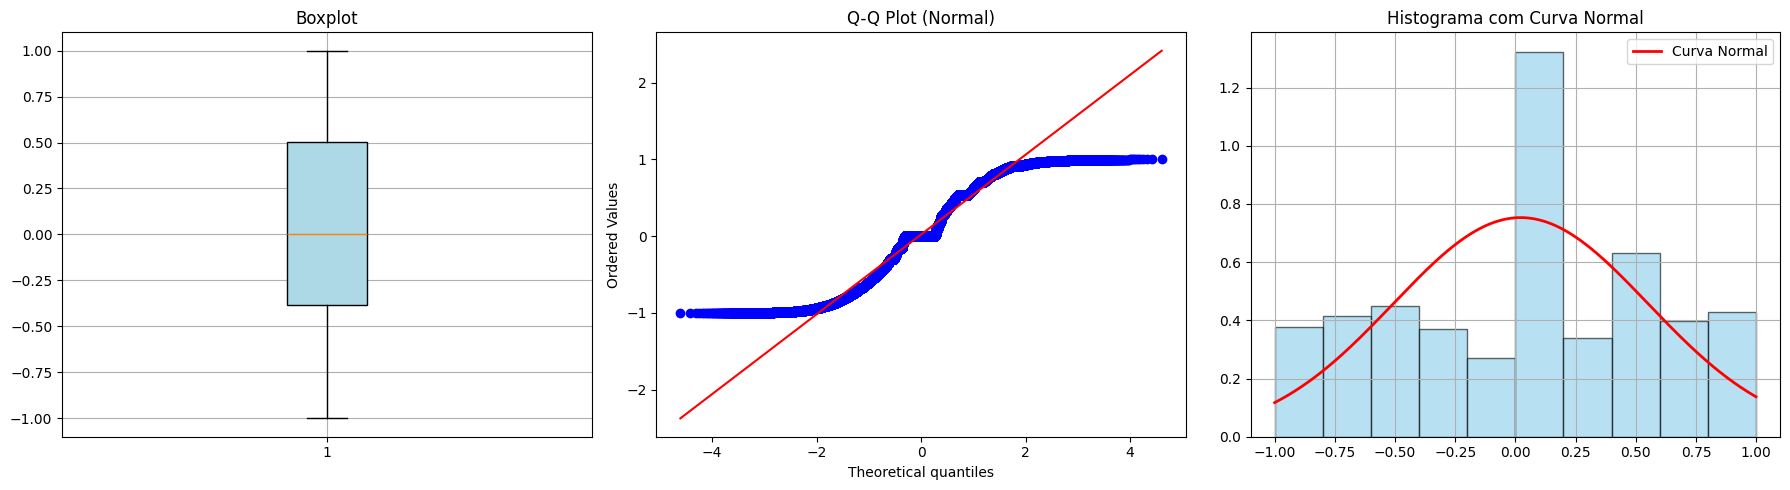


=== Testes de Normalidade ===
Shapiro-Wilk: Estat√≠stica = 0.9623, p-valor = 0.0000 -> N√£o Normal
Anderson-Darling: Estat√≠stica = 3890.3277, p-valor = 0.0000 -> N√£o Normal
Kolmogorov-Smirnov: Estat√≠stica = 0.1214, p-valor = 0.0000 -> N√£o Normal



/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 339239.
  res = hypotest_fun_out(*samples, **kwds)



=== Distribui√ß√µes ordenadas por melhor AIC ===
           beta | AIC: 462511.35 | KS-p: 0.0000
        uniform | AIC: 470017.67 | KS-p: 0.0000
    weibull_max | AIC: 517688.58 | KS-p: 0.0000
    weibull_min | AIC: 521220.78 | KS-p: 0.0000
           norm | AIC: 531617.67 | KS-p: 0.0000

Melhor Ajuste:
Distribui√ß√£o: beta
Par√¢metros: (np.float64(1.225944158103615), np.float64(1.1806490456169234), np.float64(-1.0011048537697262), np.float64(2.000338468408864))


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- Nome da Coluna: score_misinformation =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

=== Medidas de Tend√™ncia Central ===
M√©dia: 0.3123
Mediana: 0.1976
Moda: 0.1106282729517939 (Frequ√™ncia: 1019)

=== Medidas de Variabilidade ===
Amplitude: 1.0000
Desvio Padr√£o: 0.2937
Vari√¢ncia: 0.0863
Coeficiente de Varia√ß√£o (CV): 94.06%
IQR (Intervalo Interquart√≠lico): 0.4119

=== Tabela de Frequ√™ncia ===
   Intervalo  Frequ√™ncia Percentual (%)
[0.00, 0.1

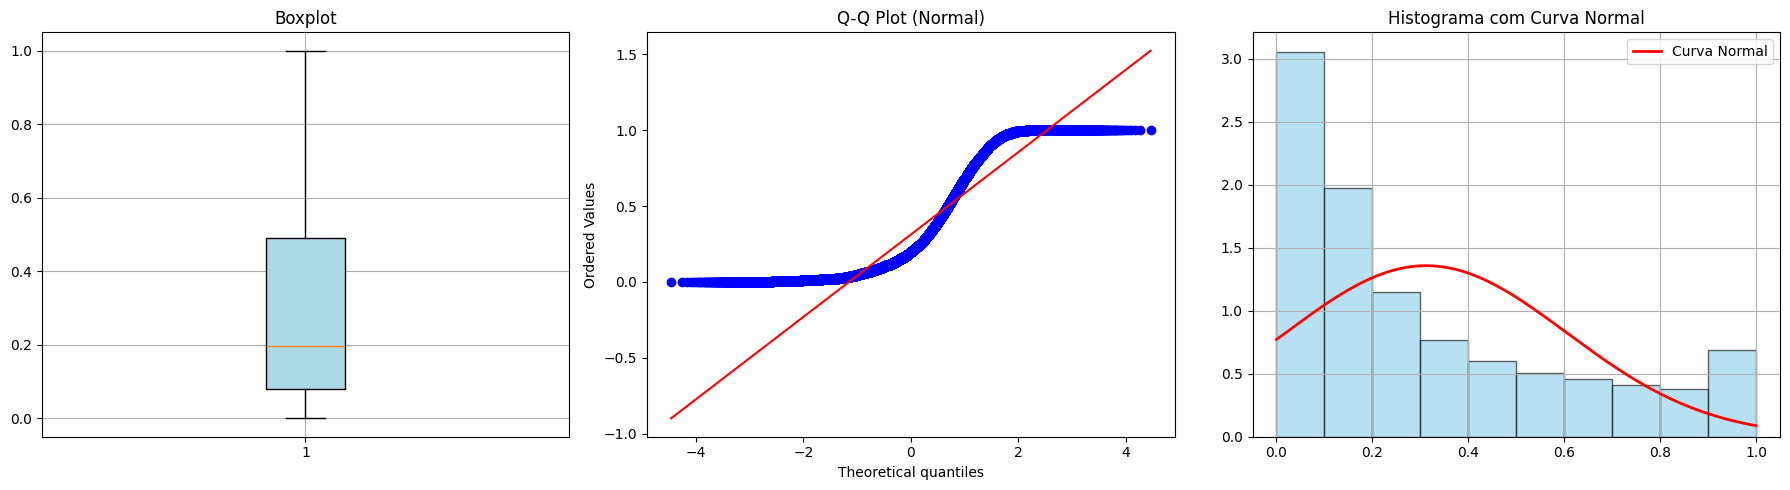


=== Testes de Normalidade ===
Shapiro-Wilk: Estat√≠stica = 0.8555, p-valor = 0.0000 -> N√£o Normal
Anderson-Darling: Estat√≠stica = 8500.4196, p-valor = 0.0000 -> N√£o Normal
Kolmogorov-Smirnov: Estat√≠stica = 0.1557, p-valor = 0.0000 -> N√£o Normal



/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 167224.
  res = hypotest_fun_out(*samples, **kwds)



=== Distribui√ß√µes ordenadas por melhor AIC ===
           beta | AIC: -66695.83 | KS-p: 0.0000
          gamma | AIC: -55042.88 | KS-p: 0.0000
    weibull_min | AIC: -54932.64 | KS-p: 0.0000
          expon | AIC: -54818.93 | KS-p: 0.0000
         pareto | AIC: -54816.93 | KS-p: 0.0000

Melhor Ajuste:
Distribui√ß√£o: beta
Par√¢metros: (np.float64(0.5970920868525846), np.float64(1.1260199279122054), np.float64(3.2731487152999994e-06), np.float64(1.0062722644155957))


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- Nome da Coluna: word_count =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

=== Medidas de Tend√™ncia Central ===
M√©dia: 42.0278
Mediana: 20.0000
Moda: 15 (Frequ√™ncia: 28896)

=== Medidas de Variabilidade ===
Amplitude: 1256.0000
Desvio Padr√£o: 74.0505
Vari√¢ncia: 5483.4797
Coeficiente de Varia√ß√£o (CV): 176.19%
IQR (Intervalo Interquart√≠lico): 26.0000

=== Tabela de Frequ√™ncia ===
         Intervalo  Frequ√™ncia Percentual (%)
    [5.00, 13

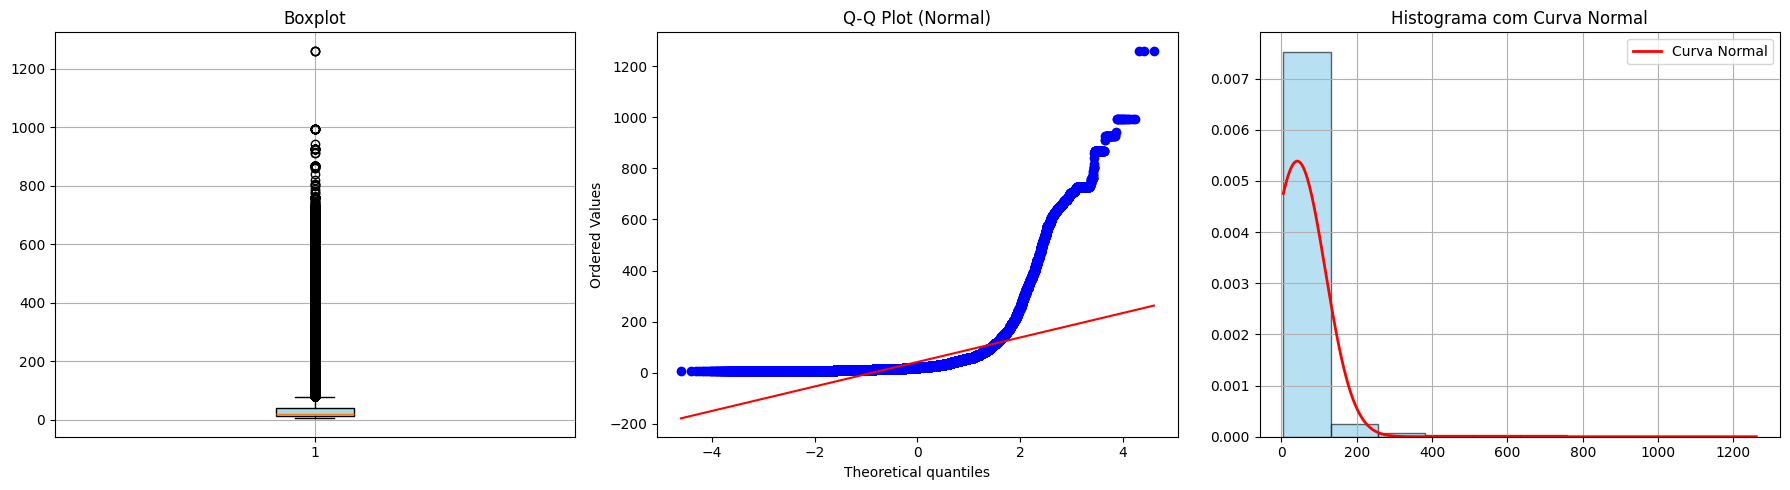


=== Testes de Normalidade ===
Shapiro-Wilk: Estat√≠stica = 0.4187, p-valor = 0.0000 -> N√£o Normal
Anderson-Darling: Estat√≠stica = inf, p-valor = 0.0000 -> N√£o Normal
Kolmogorov-Smirnov: Estat√≠stica = 0.3085, p-valor = 0.0000 -> N√£o Normal



/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 339286.
  res = hypotest_fun_out(*samples, **kwds)



=== Distribui√ß√µes ordenadas por melhor AIC ===
    weibull_min | AIC: 2999338.66 | KS-p: 0.0000
        lognorm | AIC: 3007938.20 | KS-p: 0.0000
         pareto | AIC: 3024787.54 | KS-p: 0.0000
          gamma | AIC: 3040085.68 | KS-p: 0.0000
          expon | AIC: 3129353.76 | KS-p: 0.0000

Melhor Ajuste:
Distribui√ß√£o: weibull_min
Par√¢metros: (np.float64(0.7006481670386487), np.float64(4.999999999999999), np.float64(21.52892832137652))


In [20]:
for col in df.columns:
    if (df[col].dtype == 'float64' or df[col].dtype == 'int64') and not 'id' in col:
        print('\n')
        print('=-'*30, 'Nome da Coluna:', col, '=-'*30)
        vals = df[col].values.tolist()
        print()
        centralidade_variabilidade(vals)
        print()
        plotar_diagnosticos_distribuicao(vals)
        print()
        normalidade(vals)
        print()
        best_fit_distribution(vals)

### f) Para cada par de atributos num√©ricos apresente:
		1. O Coeficiente de Correla√ß√£o apropriado
		2. Um Gr√°fico de Dispers√£o

In [21]:
def plot_correlacao_dispersao(df, x_col, y_col):

    # Remove valores n√£o num√©ricos ou nulos
    dados = df[[x_col, y_col]].dropna()
    dados = dados[np.isfinite(dados[x_col]) & np.isfinite(dados[y_col])]

    # HEXBIN
    plt.figure(figsize=(8, 5))
    plt.hexbin(dados[x_col], dados[y_col], gridsize=30, cmap='Blues')
    plt.colorbar(label='N√∫mero de pontos')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Hexbin Plot: Densidade entre {x_col} e {y_col}')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # HEATMAP DE CORRELA√á√ÉO
    corr = dados[[x_col, y_col]].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correla√ß√£o entre {x_col} e {y_col}')
    plt.tight_layout()
    plt.show()

    # SCATTER + REGRESS√ÉO
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=x_col,
        y=y_col,
        data=dados,
        alpha=0.5,
        s=50,
        edgecolor=None
    )
    sns.regplot(
        x=x_col,
        y=y_col,
        data=dados,
        scatter=False,
        color='red',
        line_kws={'linewidth': 2}
    )
    plt.title(f'Rela√ß√£o entre {x_col} e {y_col}', fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


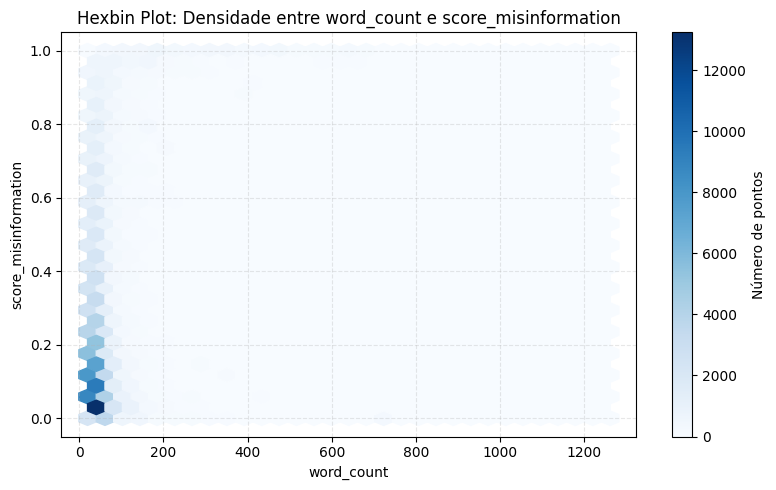

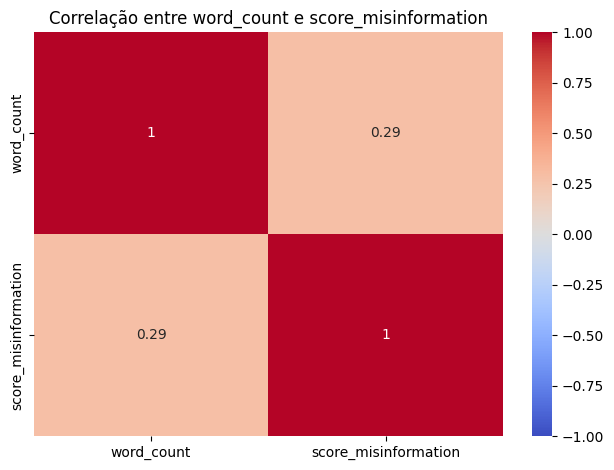

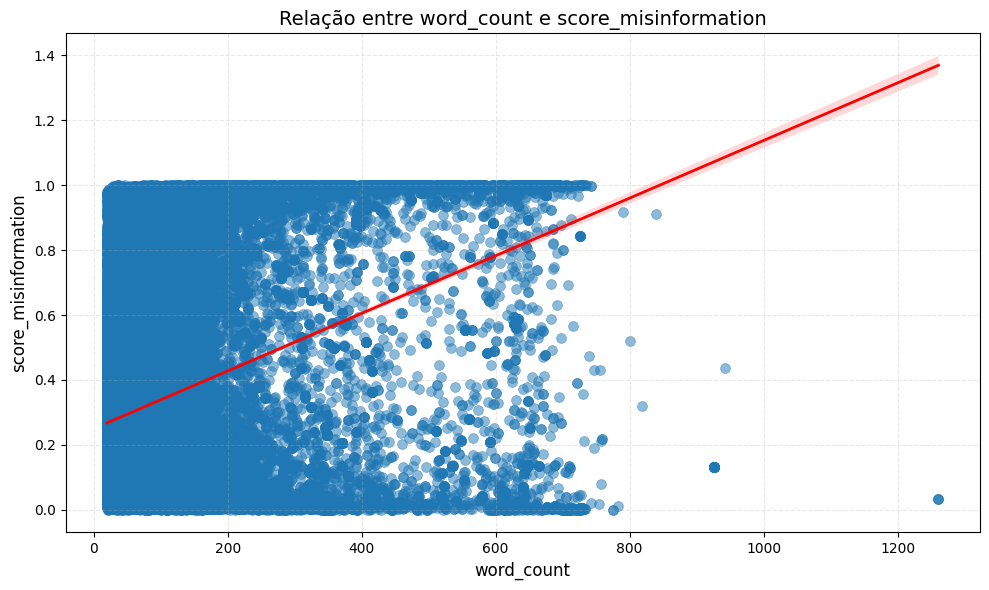

In [22]:
plot_correlacao_dispersao(df, 'word_count', 'score_misinformation')


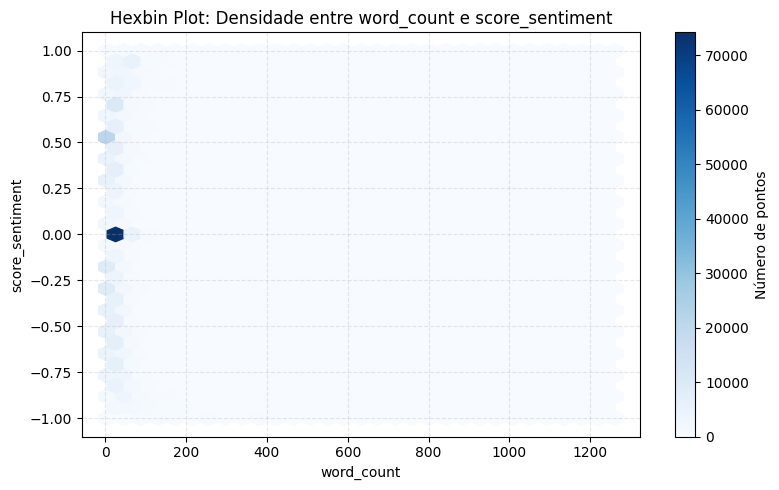

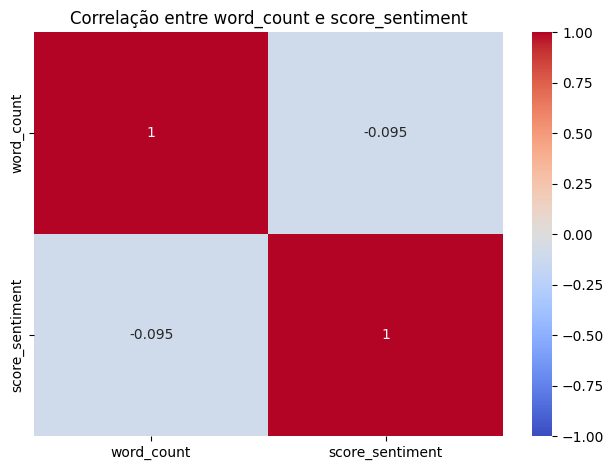

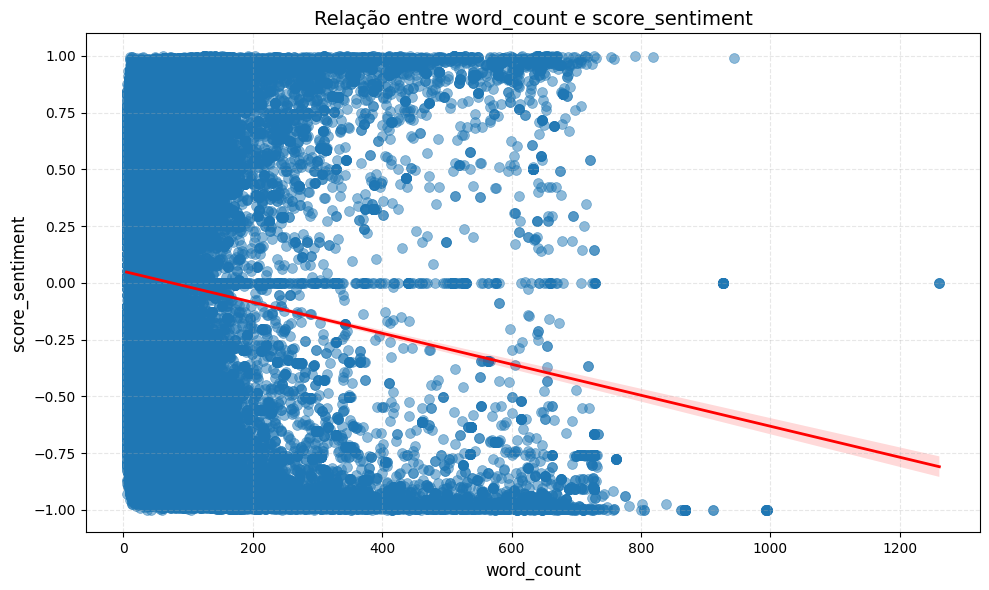

In [23]:
plot_correlacao_dispersao(df, 'word_count', 'score_sentiment')

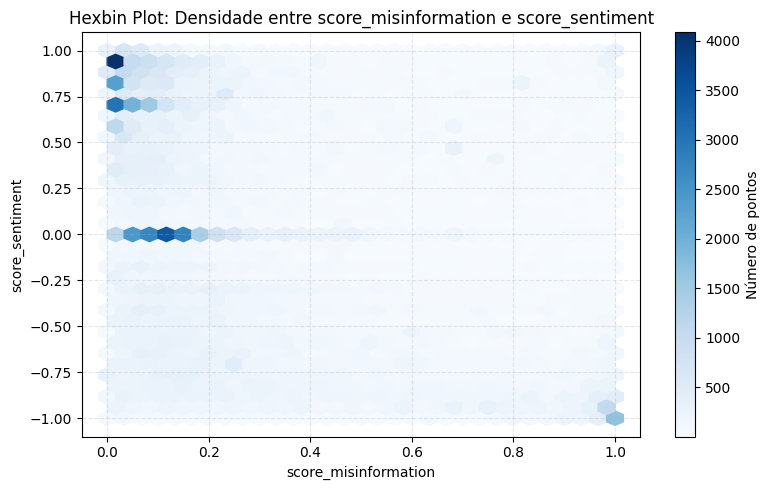

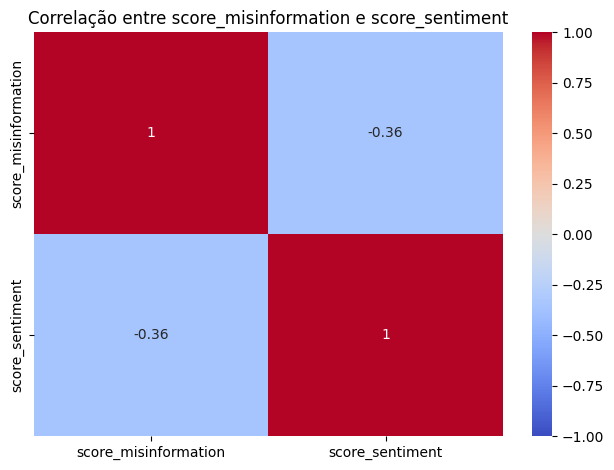

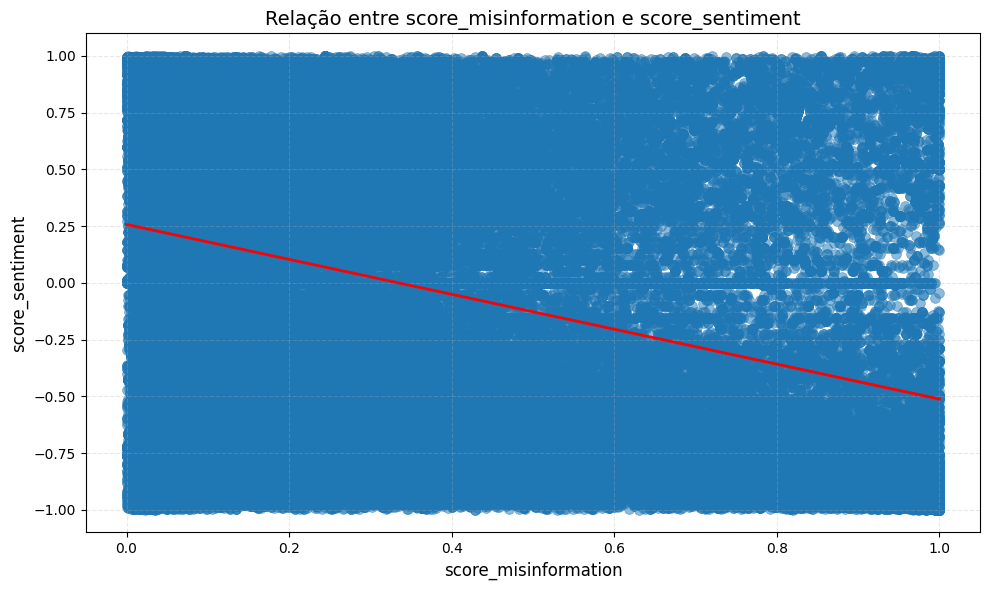

In [24]:
plot_correlacao_dispersao(df, 'score_misinformation', 'score_sentiment')

### g) Para cada par de atributos categ√≥ricos apresente

In [25]:
df_cat = df[['media_type', 'message_type', 'messenger', 'has_media']].fillna('no-media')

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0.0

def matriz_cramers_v(df, categorias=None, annot=True):
    if categorias is None:
        categorias = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    matriz = pd.DataFrame(index=categorias, columns=categorias, dtype=float)

    for col1 in categorias:
        for col2 in categorias:
            if col1 == col2:
                matriz.loc[col1, col2] = 1.0
            else:
                matriz.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz.astype(float), annot=annot, cmap="coolwarm", vmin=0, vmax=1)
    plt.title("Matriz de Cram√©r's V entre Vari√°veis Categ√≥ricas")
    plt.tight_layout()
    plt.show()
    
    return matriz


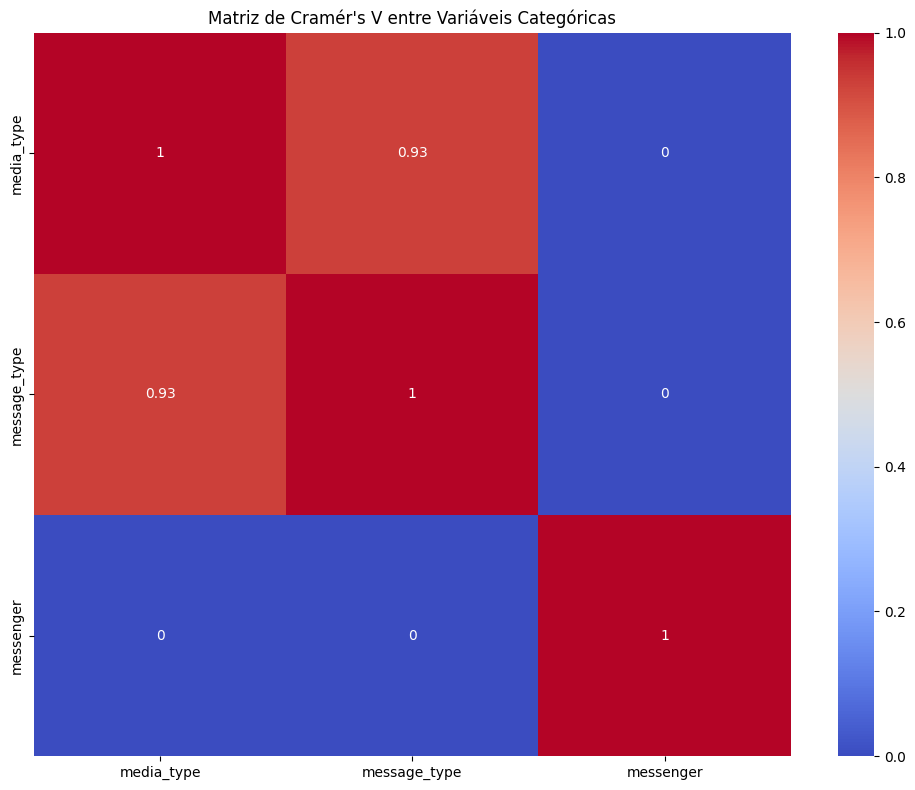

media_type  message_type  messenger
media_type      1.000000      0.931516        0.0
message_type    0.931516      1.000000        0.0
messenger       0.000000      0.000000        1.0

In [27]:
matriz_cramers_v(df_cat)

### h) Crie uma visualiza√ß√£o (gr√°fico) para apresentar:

1. As quantidades de grupos, usu√°rios e mensagens;

In [28]:
grupos = df['id_group_anonymous'].dropna().drop_duplicates().tolist()
usuarios = df['id_member_anonymous'].dropna().drop_duplicates().tolist()
msgs = df['text_content_anonymous'].dropna().drop_duplicates().tolist()

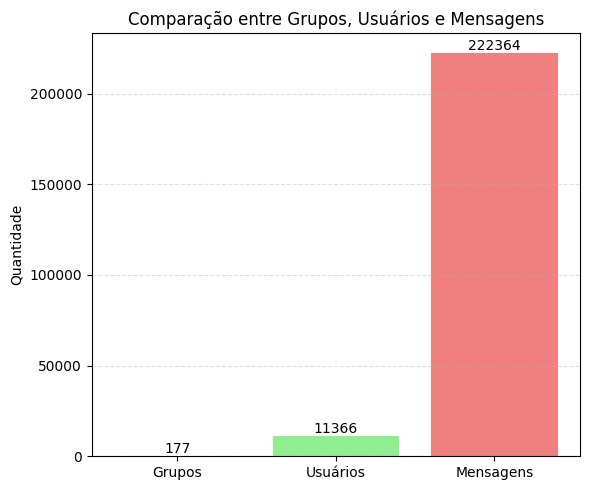

In [29]:
valores = [len(grupos), len(usuarios), len(msgs)]
categorias = ['Grupos', 'Usu√°rios', 'Mensagens']

plt.figure(figsize=(6, 5))
plt.bar(categorias, valores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Quantidade')
plt.title('Compara√ß√£o entre Grupos, Usu√°rios e Mensagens')
plt.grid(axis='y', linestyle='--', alpha=0.4)
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

2. A quantidade de mensagens que possuem apenas texto X m√≠dia;

In [30]:
df['message_type'].value_counts()

message_type
Texto          212855
Imagem          79181
Url             40625
Video            3798
Application      2802
Audio              22
Image               2
Text                1
Name: count, dtype: int64

In [31]:
texts = 0
medias = 0

for cat, val in df['message_type'].value_counts().items():
	if 'Text' in cat:
		texts += val
	else:
		medias += val

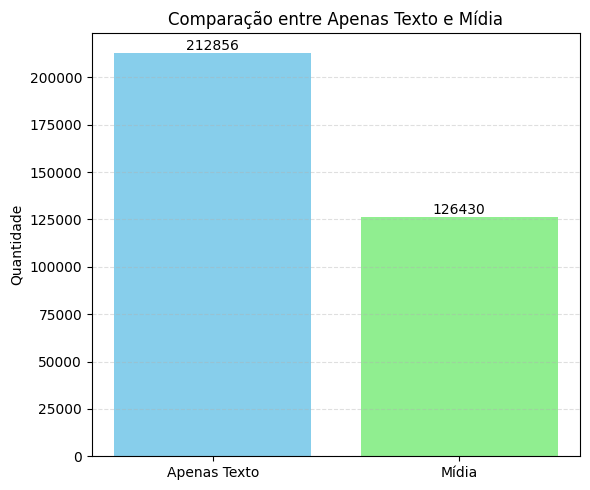

In [32]:
valores = [texts, medias]
categorias = ['Apenas Texto', 'M√≠dia']

plt.figure(figsize=(6, 5))
plt.bar(categorias, valores, color=['skyblue', 'lightgreen'])
plt.ylabel('Quantidade')
plt.title('Compara√ß√£o entre Apenas Texto e M√≠dia')
plt.grid(axis='y', linestyle='--', alpha=0.4)
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

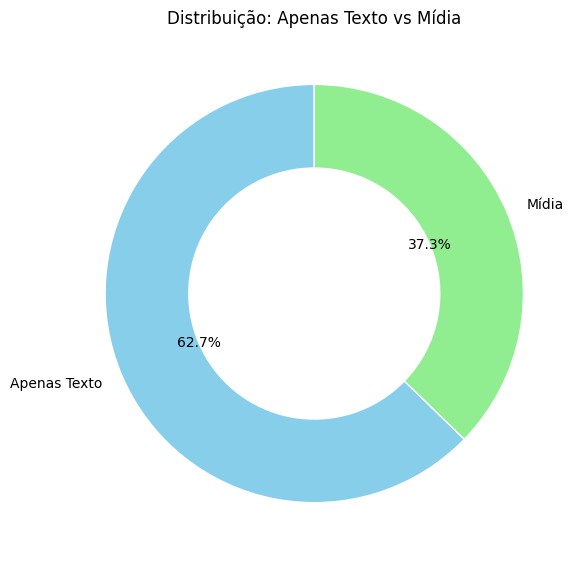

In [33]:
# Valores e categorias
valores = [texts, medias]
categorias = ['Apenas Texto', 'M√≠dia']

# Cores
cores = ['skyblue', 'lightgreen']

# Gr√°fico
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=categorias,
    colors=cores,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)

plt.title('Distribui√ß√£o: Apenas Texto vs M√≠dia')
plt.tight_layout()
plt.show()


3. Quantidade de mensagens por tipo de m√≠dia (jpg, mp4 etc);

In [34]:
result = {}

for _, media_type in df.media_type.dropna().items():
    if media_type in result.keys():
        result[media_type] += 1
    else:
        result[media_type] = 1

In [35]:
len(result.keys())

41

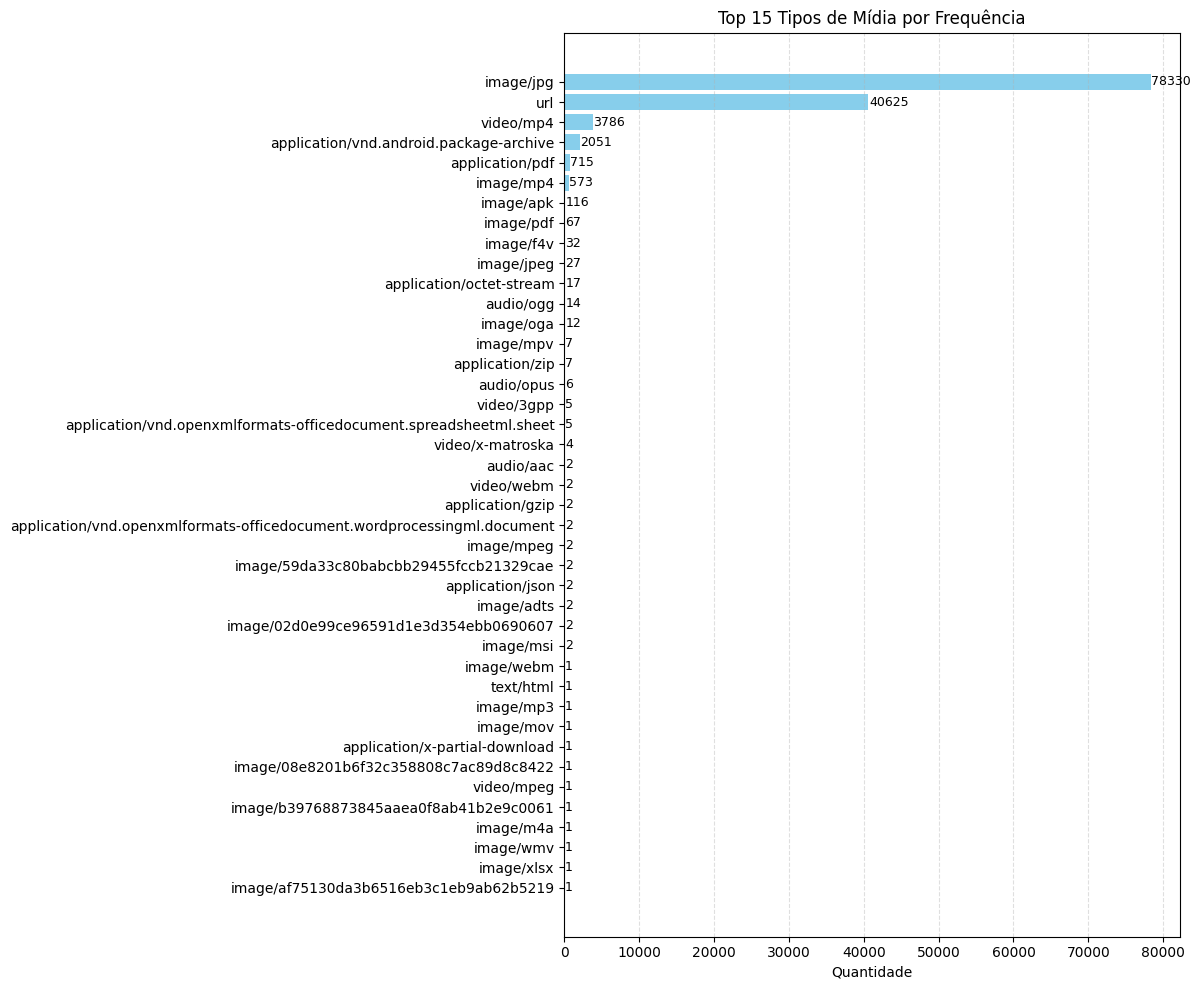

In [36]:
df_midia = pd.DataFrame(list(result.items()), columns=['tipo', 'quantidade'])
df_midia = df_midia.sort_values(by='quantidade', ascending=False).head(41)

# Plotar
plt.figure(figsize=(12, 10))
plt.barh(df_midia['tipo'], df_midia['quantidade'], color='skyblue')
plt.xlabel('Quantidade')
plt.title('Top 15 Tipos de M√≠dia por Frequ√™ncia')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Mostrar valores nas barras
for i, v in enumerate(df_midia['quantidade']):
    plt.text(v + 100, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

4. A rela√ß√£o entre a quantidade de mensagens e a quantidade de palavras presente nas mensagens;

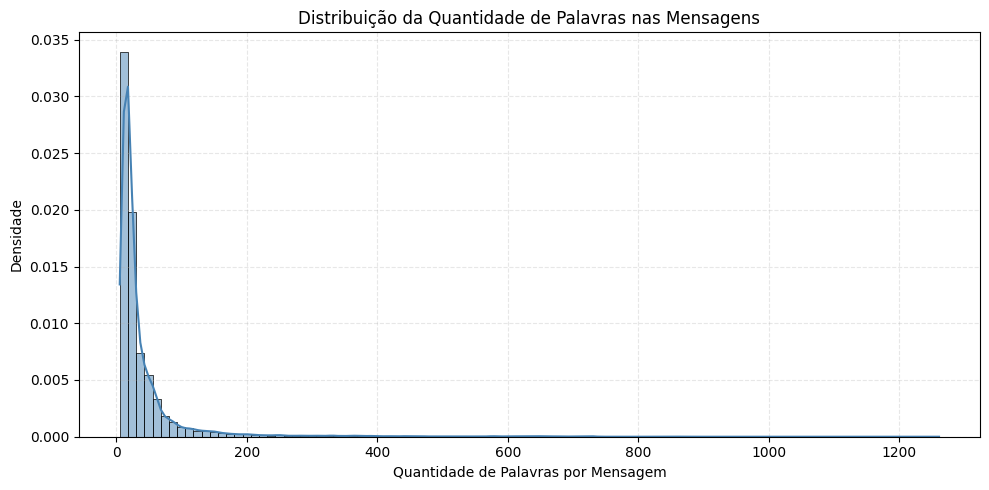

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], kde=True, stat='density', bins=100, color='steelblue')
plt.xlabel('Quantidade de Palavras por Mensagem')
plt.ylabel('Densidade')
plt.title('Distribui√ß√£o da Quantidade de Palavras nas Mensagens')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

5 ~ 9 Inv√°lidas

10. As 30 URLs que mais se repetem (mais compartilhadas);

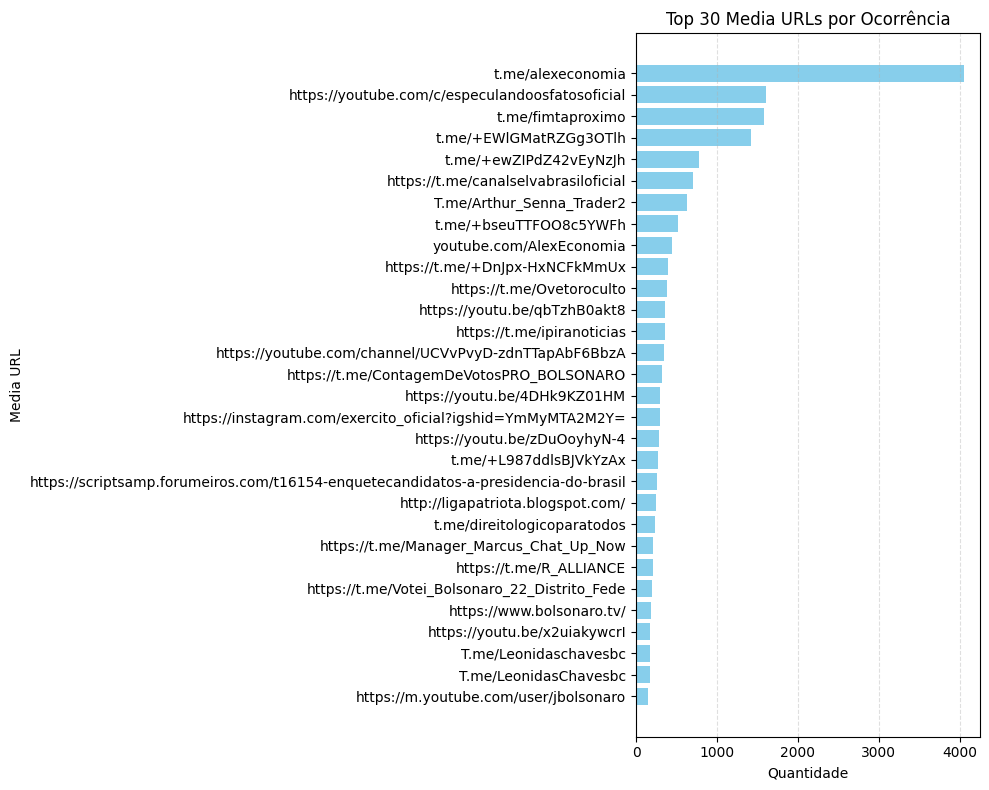

In [38]:
top_urls = (
    df[df['media_url'].notna()]
    .groupby('media_url')
    .size()
    .reset_index(name='qtde_url')
    .sort_values(by='qtde_url', ascending=False)
    .head(30)
)

# 2. Plotagem
plt.figure(figsize=(10, 8))
plt.barh(top_urls['media_url'], top_urls['qtde_url'], color='skyblue')
plt.xlabel('Quantidade')
plt.ylabel('Media URL')
plt.title('Top 30 Media URLs por Ocorr√™ncia')
plt.gca().invert_yaxis()  # Coloca o maior no topo
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

11. Os 30 dom√≠nios que mais se repetem (mais compartilhados);

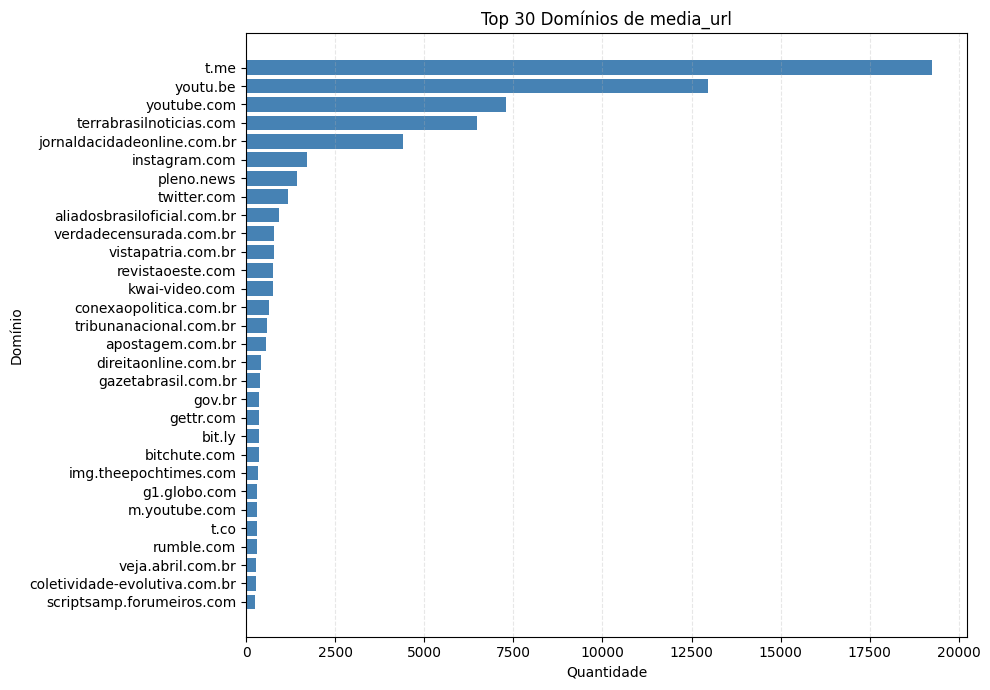

In [39]:
df_filtrado = df[df['media_url'].notna()].copy()

#Extrai dom√≠nio com regex e lowercase
df_filtrado['dominio'] = df_filtrado['media_url'].str.extract(r'^(?:https?://)?(?:www\.)?([^/]+)')[0].str.lower()

# Conta por dom√≠nio
top_dominios = (
    df_filtrado.groupby('dominio')
    .size()
    .reset_index(name='total')
    .sort_values(by='total', ascending=False)
    .head(30)
)

# Plotagem
plt.figure(figsize=(10, 7))
plt.barh(top_dominios['dominio'], top_dominios['total'], color='steelblue')
plt.xlabel('Quantidade')
plt.ylabel('Dom√≠nio')
plt.title('Top 30 Dom√≠nios de media_url')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

12. Os 30 usu√°rios mais ativos;

In [40]:
top_usuarios = (
    df[df['id_member_anonymous'].notna() & (df['text_content_anonymous'].notna() | df['media'].notna())]
    .groupby('id_member_anonymous')
    .size()
    .reset_index(name='count_atividade')
    .rename(columns={'id_member_anonymous': 'users'})
    .sort_values(by='count_atividade', ascending=False)
    .head(30)
)

top_usuarios 

users  count_atividade
7616   abe534d581ec6d552243d6955d3c3cd8            12289
998    1665e22b0f564cd46d343f7677014821             5452
1191   1ac091b8ed5c4e42383f1b4ff4cc9b2d             3260
8820   c743967449a387ad2c1c7e03b2c45b36             3017
9420   d49f81df0c75d1d72bee6c5b2d707da0             1571
10745  f233cf8b1d4ede06f32199a7e0081bf5             1088
10363  e8fd8fee8c39342d37993775da7756d5             1027
10307  e7998863ac2a40086657fab4a6b463c9              921
8533   c052c859b42c5a1923c22f5a201de746              831
11114  fa582c9e95da255e44f4c198d0daf3df              817
5269   773b9bd5b02a2e96f9d732c29bfcb663              761
3845   56b8359fd127312651b80b8ed8030085              627
5240   7696d5103cdb8ac352d748a1db1126b0              626
7242   a378e9743fa3ca297df321cfa0e7cf6a              612
11173  fbbbfb737acb18812f7de2400841abc3              593
3832   566ba5c5eeeac2fc18b65965c3909a1f              582
10217  e5e3e38d433016adf62ea34432853a3c              580
6883   9b34f45b5f8af4c37ba9ec1ebe2e3606              527
3725   53e74af95497f943c524abaaa9482e33              525
10851  f4561a21fb26cfbebf48dcd5c557f82f              521
7250   a398999c55f8d6f0c65760522ae12e45              520
8447   beb77036ff26e78865da19310ac95169              512
1707   26b496125c8b6773bce453e14f172430              505
5522   7d41f1a2df245b0cc870f546c2aead0b              483
8014   b4ce87d44421ef3d2c4710051df5fe40              478
8402   bd7859770eef94f34d0344a5397c5443              469
5391   79fa510c3ab44548d903284ab9162c9d              464
6710   9794a13f91433216821ad18624372498              462
4132   5d321b03e74b751ac577ef022350306d              451
2792   3f64a652deccf6273d7d769252bdfb46              444

13. Rela√ß√£o entre quantidade de mensagens contendo somente texto e mensagens contendo m√≠dia dos usu√°rios mais ativos.

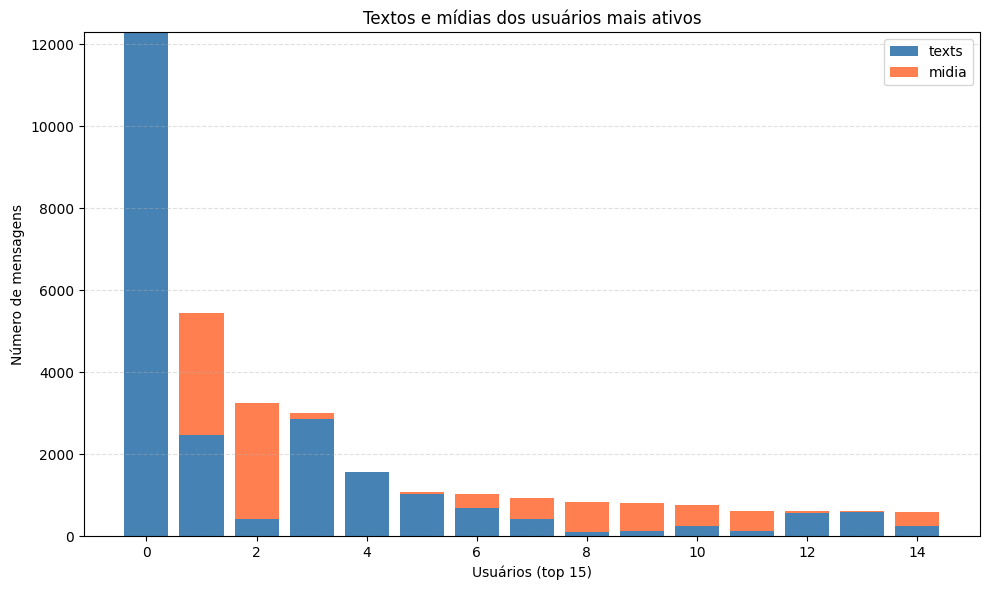

In [41]:
# Filtrar mensagens com texto ou m√≠dia
df_filtrado = df[df['id_member_anonymous'].notna() & (df['text_content_anonymous'].notna() | df['media'].notna())]

# Separar textos e m√≠dias
df_texts = df_filtrado[df_filtrado['media'].isna()]
df_midia = df_filtrado[df_filtrado['media'].notna()]

# Contar por usu√°rio
contagem_textos = df_texts.groupby('id_member_anonymous').size().reset_index(name='texts')
contagem_midia = df_midia.groupby('id_member_anonymous').size().reset_index(name='midia')

# Juntar as contagens
df_contagem = pd.merge(contagem_textos, contagem_midia, how='outer', on='id_member_anonymous').fillna(0)

# Calcular total e pegar os mais ativos
df_contagem['total'] = df_contagem['texts'] + df_contagem['midia']
top_usuarios = df_contagem.sort_values(by='total', ascending=False).head(15).reset_index(drop=True)

# Plotar
plt.figure(figsize=(10, 6))
plt.bar(top_usuarios.index, top_usuarios['texts'], label='texts', color='steelblue')
plt.bar(top_usuarios.index, top_usuarios['midia'], bottom=top_usuarios['texts'], label='midia', color='coral')

plt.title('Textos e m√≠dias dos usu√°rios mais ativos')
plt.xlabel('Usu√°rios (top 15)')
plt.ylabel('N√∫mero de mensagens')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

14. Os 30 usu√°rios que mais compartilharam texto;

In [42]:
top_text_users = (
    df[df['id_member_anonymous'].notna()]
    .groupby('id_member_anonymous')['text_content_anonymous']
    .count()
    .reset_index(name='count_messages')
    .rename(columns={'id_member_anonymous': 'users'})
    .sort_values(by='count_messages', ascending=False)
    .head(30)
)

top_text_users  


users  count_messages
7616   abe534d581ec6d552243d6955d3c3cd8           12289
998    1665e22b0f564cd46d343f7677014821            5452
1191   1ac091b8ed5c4e42383f1b4ff4cc9b2d            3260
8820   c743967449a387ad2c1c7e03b2c45b36            3017
9420   d49f81df0c75d1d72bee6c5b2d707da0            1571
10745  f233cf8b1d4ede06f32199a7e0081bf5            1088
10363  e8fd8fee8c39342d37993775da7756d5            1027
10307  e7998863ac2a40086657fab4a6b463c9             921
8533   c052c859b42c5a1923c22f5a201de746             831
11114  fa582c9e95da255e44f4c198d0daf3df             817
5269   773b9bd5b02a2e96f9d732c29bfcb663             761
3845   56b8359fd127312651b80b8ed8030085             627
5240   7696d5103cdb8ac352d748a1db1126b0             626
7242   a378e9743fa3ca297df321cfa0e7cf6a             612
11173  fbbbfb737acb18812f7de2400841abc3             593
3832   566ba5c5eeeac2fc18b65965c3909a1f             582
10217  e5e3e38d433016adf62ea34432853a3c             580
6883   9b34f45b5f8af4c37ba9ec1ebe2e3606             527
3725   53e74af95497f943c524abaaa9482e33             525
10851  f4561a21fb26cfbebf48dcd5c557f82f             521
7250   a398999c55f8d6f0c65760522ae12e45             520
8447   beb77036ff26e78865da19310ac95169             512
1707   26b496125c8b6773bce453e14f172430             505
5522   7d41f1a2df245b0cc870f546c2aead0b             483
8014   b4ce87d44421ef3d2c4710051df5fe40             478
8402   bd7859770eef94f34d0344a5397c5443             469
5391   79fa510c3ab44548d903284ab9162c9d             464
6710   9794a13f91433216821ad18624372498             462
4132   5d321b03e74b751ac577ef022350306d             451
2792   3f64a652deccf6273d7d769252bdfb46             444

15. Os 30 usu√°rios que mais compartilharam m√≠dias;

In [43]:
top_media_users = (
    df[(df['has_media'] == True) & df['id_member_anonymous'].notna()]
    .groupby('id_member_anonymous')
    .size()
    .reset_index(name='count_midia')
    .rename(columns={'id_member_anonymous': 'users'})
    .sort_values(by='count_midia', ascending=False)
    .head(30)
)

top_media_users


users  count_midia
277   1665e22b0f564cd46d343f7677014821         2972
327   1ac091b8ed5c4e42383f1b4ff4cc9b2d         2843
2366  c052c859b42c5a1923c22f5a201de746          736
3068  fa582c9e95da255e44f4c198d0daf3df          701
1475  773b9bd5b02a2e96f9d732c29bfcb663          521
1082  56b8359fd127312651b80b8ed8030085          501
2840  e7998863ac2a40086657fab4a6b463c9          493
1047  53e74af95497f943c524abaaa9482e33          460
1856  9794a13f91433216821ad18624372498          458
1154  5d321b03e74b751ac577ef022350306d          449
790   3f64a652deccf6273d7d769252bdfb46          433
2341  beb77036ff26e78865da19310ac95169          419
775   3e49fd40fd973ee1b8f1a6d58feb4a54          412
2879  eaef2dbdc2914b034116569bc8919403          374
3087  fbbbfb737acb18812f7de2400841abc3          351
1849  96c8dffb29c65cd1905239dc64196f03          346
1793  92a98298316caf5bdbd65acfc20908a7          339
1513  79fa510c3ab44548d903284ab9162c9d          338
1204  6134f475127170f39fe48d53f874080e          331
2853  e8fd8fee8c39342d37993775da7756d5          329
803   40743c2ea5139af088057763ab069b1a          318
1079  566ba5c5eeeac2fc18b65965c3909a1f          296
2429  c6f406117d909c73ea9c11de8560f5c3          290
995   4f7d493f0f6222d56e5b19a4f7c336cc          280
955   4d1389bd32de5dfc0a3fab14573131ac          280
1904  9b34f45b5f8af4c37ba9ec1ebe2e3606          280
1438  74ce4ba0ef6c0d51e6a508b0bb2d37b8          277
428   22da7e558d613074dc701f8a40bc955b          277
187   0f1a0bc54bfb4c24251e7a35fc02848d          275
2941  f08cb953e68eddae5d1e15edf8c8df0b          268

16. As 30 mensagens mais compartilhadas;

In [44]:
def normalize_text(text):
    if pd.isna(text):
        return ''
    
    text = text.lower()
    text = re.sub(r'[√°√†√£√¢√§]', 'a', text)
    text = re.sub(r'[√©√®√™√´]', 'e', text)
    text = re.sub(r'[√≠√¨√Æ√Ø]', 'i', text)
    text = re.sub(r'[√≥√≤√µ√¥√∂]', 'o', text)
    text = re.sub(r'[√∫√π√ª√º]', 'u', text)
    text = re.sub(r'[√ß]', 'c', text)
    text = re.sub(r'[^a-z0-9 ]', '', text)         # remove especiais
    text = re.sub(r'\s+', ' ', text)               # m√∫ltiplos espa√ßos
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text) # remove palavras com letras repetidas
    return text.strip()


In [45]:
df_textos = df[df['text_content_anonymous'].notna()].copy()
df_textos['normalized_text'] = df_textos['text_content_anonymous'].apply(normalize_text)

top_msns = (
    df_textos.groupby('normalized_text')
    .size()
    .reset_index(name='total')
    .sort_values(by='total', ascending=False)
    .head(30)
)

top_msns

normalized_text  total
186931  this community was blocked in brazil following...  17422
204026  vpn taqiqlangan saytlardan bu vpn orqali ozbek...   1019
14870   amerikalik ayolni arab erkaklari tomonidan zor...    632
204186  we had no choice but to remain in the shadows ...    480
90433   httpstmecanalselvabrasiloficialselva brasil of...    467
50691   e conhecereis a verdade e a verdade vos libert...    450
0                                                            436
635     14 vpn watch sex with a 14yearold girl on porn...    400
25277   bem vindoa ao grupo ipira noticias compartilhe...    358
96180                inscreva se no canal tmefimtaproximo    232
215982  welcome user professional tool for managing te...    216
96863   invista conosco e receba seu lucro esta seguro...    208
201182                     video de avany ferreira muller    195
201393                    video de maria teresa d valente    189
147062  para quem gosta de medicina natural esse e sem...    188
81027                      foto de maria teresa d valente    184
131209  o meu amigo nao sou infiltrado meu voto foi pa...    172
201452                           video de r a s g a n d o    171
175175  sem legendas inscreva se no canal tmefimtaproximo    158
87012   grupo para organizar 200 mil eleitores do bols...    152
61442   envie seu pedido oi ola quaoquer investir quer...    145
25881   boa noite a todos o que eu vou dizer e serio a...    135
167337  regras do grupo 1 regra do grupo e respeito ao...    127
126543  noticia de dentro do quartel os militares ja q...    120
59748   encerrar modo noturno de agora em diante os us...    117
198073  vamos seguir o instagram do exercito brasileir...    113
102123  juntese a nos tambem e mantenhase informado cl...    110
152517  pessoal estamos correndo contra o tempo para i...    107
201320                            video de jane macoletti    105
201386                 video de maria emilia gadelha serr    103

17. As 30 mensagens mais compartilhadas em grupos diferentes;

In [46]:
# Filtrar mensagens com grupo e texto
df_filtrado = df[
    df['text_content_anonymous'].notna() &
    df['id_group_anonymous'].notna()
].copy()

# Normalizar texto
df_filtrado['normalized_text'] = df_filtrado['text_content_anonymous'].apply(normalize_text)

# Remover vazios
df_filtrado = df_filtrado[df_filtrado['normalized_text'].str.len() > 0]

# Contar grupos √∫nicos por mensagem
top_msgs_grupos = (
    df_filtrado.groupby('normalized_text')['id_group_anonymous']
    .nunique()
    .reset_index(name='total_grupos')
    .sort_values(by='total_grupos', ascending=False)
    .head(30)
)

top_msgs_grupos

normalized_text  total_grupos
186930  this community was blocked in brazil following...            59
25880   boa noite a todos o que eu vou dizer e serio a...            36
88286   hoje as 18 horas no canal inteligencia ltda do...            35
22512   atencao chamada urgente patriotas do brasil di...            31
144486  os ptistas nao quer que agente mostre que voto...            29
12179    ajudem a subir a janonesamigodepedofilopor favor            29
44861   de nada ira adiantar fiscalizar as urnas se na...            29
32586   brasileiros pior de que voces perderem seus co...            28
143869  os eleitores que ja enviou nao precisa mais en...            28
103356  lancaram o lulaflix uma coletanea com o que de...            27
153401  pessoal poste seu comprovante de votosera disp...            27
173833  se voce acredita que bolsonaro ganhou no prime...            27
165917  queridos amigos patriotas segue o sentimento d...            27
153672  pessoal se voce acredita que bolsonaro ganhou ...            27
144040  os grupos meu voto e bolsonaro 22 ficaram aber...            27
160337  prezados brasileiros patriotas saudacoesinscri...            27
61391   enviando por email habeas corpus stj povo assi...            27
61395              enviando por email requerimento gsipdf            27
61394   enviando por email representacao prisao minale...            27
162387  quando estiver zero membroaqui teremos a certe...            26
42656   contra tudo e contra todos tivemos no 1 turno ...            26
42389   contagem publica de votos pro bolsonaro22 2 tu...            26
144847  ou crer em deus e confia em nosso presidente b...            25
672     1466497 assistindo agora transmissao iniciada ...            25
130732  o lula e o lula e o lula e o lula e o lula e o...            25
3690                a explicacao da maior fraude do mundo            25
100907  jair bolsonaro e o presidente da republica ele...            25
22391   atencao alerta a todosa esquerda esta agindo n...            25
27404   bolsonaro bate recorde de lula em podcastbolso...            25
100909  jair bolsonaro e o presidente da republica ele...            25

18. Mensagens id√™nticas compartilhadas pelo mesmo usu√°rio (e suas quantidades);

In [47]:
df_filtrado = df[
    df['text_content_anonymous'].notna() &
    df['id_member_anonymous'].notna()
].copy()

df_filtrado['normalized_text'] = df_filtrado['text_content_anonymous'].apply(normalize_text)

df_filtrado = df_filtrado[df_filtrado['normalized_text'].str.len() > 0]

repeticoes = (
    df_filtrado.groupby(['id_member_anonymous', 'normalized_text'])
    .size()
    .reset_index(name='total_repeticoes')
)

repeticoes = repeticoes[repeticoes['total_repeticoes'] > 1]
repeticoes = repeticoes.sort_values(by='total_repeticoes', ascending=False)

repeticoes 

id_member_anonymous  \
104572  f233cf8b1d4ede06f32199a7e0081bf5   
86855   c743967449a387ad2c1c7e03b2c45b36   
45166   7696d5103cdb8ac352d748a1db1126b0   
7251    1665e22b0f564cd46d343f7677014821   
61051   a398999c55f8d6f0c65760522ae12e45   
...                                  ...   
22805   31f49a13b6ea413aab34aa1e885a65b9   
22883   32783be6c9de86a5b268719d4a151a93   
22885   32783be6c9de86a5b268719d4a151a93   
22951   32783be6c9de86a5b268719d4a151a93   
22955   3289207e748f5a3f197e7ec6d56fec09   

                                          normalized_text  total_repeticoes  
104572  this community was blocked in brazil following...               838  
86855   this community was blocked in brazil following...               532  
45166   this community was blocked in brazil following...               530  
7251    bem vindoa ao grupo ipira noticias compartilhe...               357  
61051   this community was blocked in brazil following...               308  
...                                                   ...               ...  
22805   urgente indignado general heleno se manifesta ...                 2  
22883   contra tudo e contra todos tivemos no 1 turno ...                 2  
22885   em pdf httpsbitly3azpwzh para ouvir httpsbitly...                 2  
22951   vestir com modestia com muito pudor olhai como...                 2  
22955   pregunto a cada grupo que voy lo siguiente alg...                 2  

[12559 rows x 3 columns]

19. Mensagens id√™nticas compartilhadas pelo mesmo usu√°rio em grupos distintos (e suas quantidades)

In [48]:
df_filtrado = df[
    df['text_content_anonymous'].notna() &
    df['id_member_anonymous'].notna() &
    df['id_group_anonymous'].notna()
].copy()
df_filtrado['normalized_text'] = df_filtrado['text_content_anonymous'].apply(normalize_text)
df_filtrado = df_filtrado[df_filtrado['normalized_text'].str.len() > 0]
mensagens_multigrupos = (
    df_filtrado.groupby(['id_member_anonymous', 'normalized_text'])['id_group_anonymous']
    .nunique()
    .reset_index(name='total_grupos')
)
mensagens_multigrupos = mensagens_multigrupos[mensagens_multigrupos['total_grupos'] > 1]
mensagens_multigrupos = mensagens_multigrupos.sort_values(by='total_grupos', ascending=False)
mensagens_multigrupos

id_member_anonymous  \
62022   a7840e7844020149e197272748965862   
22869   326d0a2f1bc5a1ede446fcf5dc31ff2e   
22864   326d0a2f1bc5a1ede446fcf5dc31ff2e   
19572   29dda76df3384c28a07e8bad1ee9ceed   
31174   4e93f1d3c83fd6041314517363b14ed5   
...                                  ...   
41      0049ead7ba0fe5920ee42c7ac245e073   
31      0049ead7ba0fe5920ee42c7ac245e073   
24      0049ead7ba0fe5920ee42c7ac245e073   
22      0036df952bd1bbdd86f79233aff6b6f3   
109990  ffe20debda77f07fa40f1362f5c078d4   

                                          normalized_text  total_grupos  
62022   alertaesse grupo foi criado pela esquerda com ...            16  
22869   urgentissimo esse grupo e uma fraude saiam des...            14  
22864   bomba bombavcs estao achando que irao consegui...            12  
19572   boa noite a todos o que eu vou dizer e serio a...            11  
31174   pessoal nao envie seus comprovantes de votacao...            10  
...                                                   ...           ...  
41      creio que a propria esquerda esta fazendo esse...             2  
31      ao vivo multidao em igreja apoia bolsonaro pre...             2  
24      a midia militantes esta ressuscitando video an...             2  
22      lista de grupos telegramparalisacaoentrem no s...             2  
109990  oracao ao senhor dos exercitos de deus compart...             2  

[8383 rows x 3 columns]

20. Os 30 unigramas, bigramas e trigramas mais compartilhados (ap√≥s a remo√ß√£o de stop words);

In [49]:
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese')) | set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


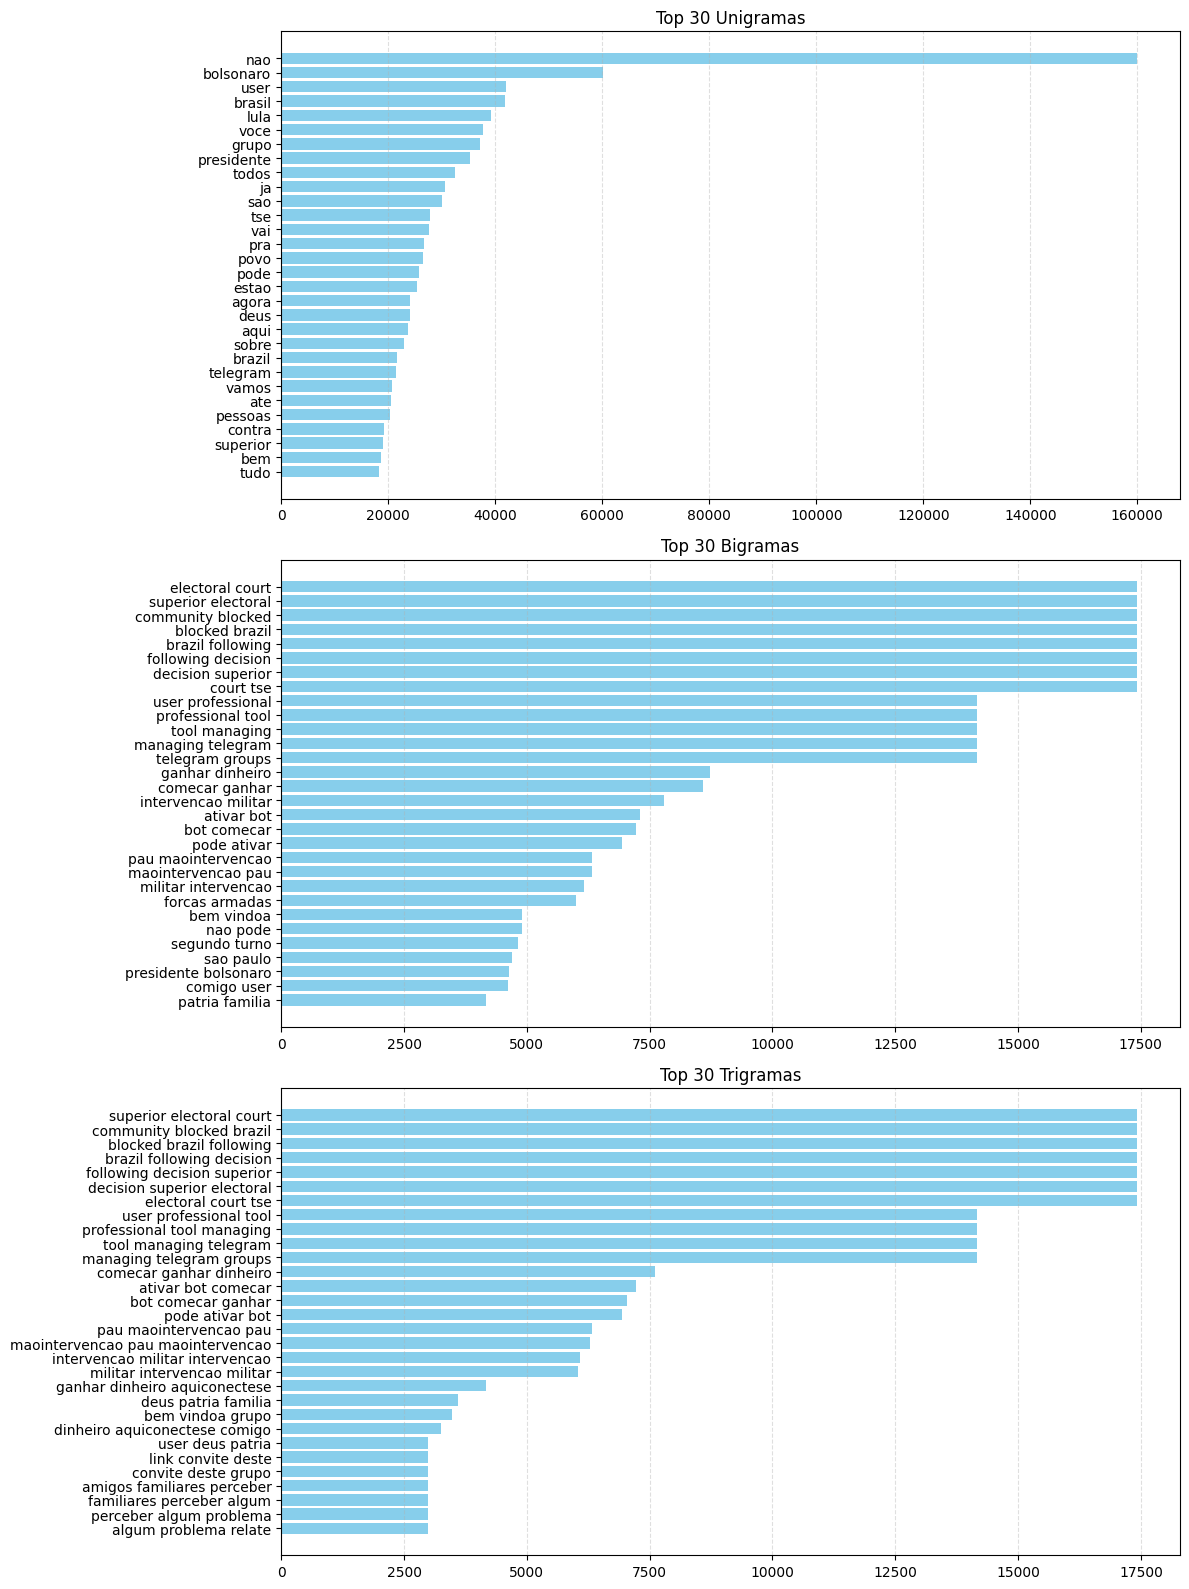

In [50]:
df_filtrado = df[df['text_content_anonymous'].notna()].copy()
df_filtrado['normalized'] = df_filtrado['text_content_anonymous'].apply(normalize_text)

all_tokens = []
bigrams_list = []
trigrams_list = []

for texto in df_filtrado['normalized']:
    tokens = [t for t in texto.split() if t not in stop_words]
    all_tokens.extend(tokens)
    bigrams_list.extend([' '.join(b) for b in ngrams(tokens, 2)])
    trigrams_list.extend([' '.join(t) for t in ngrams(tokens, 3)])

top_unigrams = Counter(all_tokens).most_common(30)
top_bigrams = Counter(bigrams_list).most_common(30)
top_trigrams = Counter(trigrams_list).most_common(30)

fig, axs = plt.subplots(3, 1, figsize=(12, 16))

def plot_ngram(ax, data, title):
    labels, values = zip(*data)
    ax.barh(labels, values, color='skyblue')
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.4)

plot_ngram(axs[0], top_unigrams, 'Top 30 Unigramas')
plot_ngram(axs[1], top_bigrams, 'Top 30 Bigramas')
plot_ngram(axs[2], top_trigrams, 'Top 30 Trigramas')

plt.tight_layout()
plt.show()

21. As 30 mensagens mais positivas (distintas);

In [51]:
df_sent = df[df['text_content_anonymous'].notna() & df['score_sentiment'].notna()].copy()
df_sent['normalized_text'] = df_sent['text_content_anonymous'].apply(normalize_text)
df_unicas = (
    df_sent.sort_values(by='score_sentiment', ascending=False)
    .drop_duplicates(subset='normalized_text', keep='first')
)
top_positivas = df_unicas[['text_content_anonymous', 'score_sentiment']].head(30)

top_positivas

text_content_anonymous  score_sentiment
190829  Shemoneh Esreh ‚Äì Amid√° ‚Äì A Grande Ora√ß√£o\n\n ,...           0.9992
182658  Pensa direita, n√£o √© correto compartilhar um v...           0.9990
103522  MENTIROSA!!!\n\n\nPensa direita, n√£o √© correto...           0.9990
202948  ◊ë◊ï◊†◊î ◊ô◊®◊ï◊©◊ú◊ô◊ù,¬†Bo'ne Yetrushalayim¬†- Ben√ß√£o da ...           0.9989
6126    Os Sete Samurais \n \nQuando falamos sobre For...           0.9988
186190  MANIFESTO √Ä NA√á√ÉO BRASILEIRA\n\nEM DEFESA DO B...           0.9987
27483   Ol√° ,\n\nUM AMIGO ME PERGUNTOU EM QUEM EU VOTE...           0.9986
85401   BOM DIA A TODOS. ENTENDO QUE ESTAMOS VIVENDO D...           0.9986
285516  Uma forma bem legal\nPara quem ainda n√£o sabe ...           0.9985
159194  ¬†\nA Viva Esperan√ßa\n\nDepois das sauda√ß√µes in...           0.9985
365285  ‚ÄúPaz!‚Äù\nObrigada amados meus, por mais esta An...           0.9984
21284   Yom Ha-Shishi (O SEXTO DIA)?\n\nE agora, sem m...           0.9984
81092   VOC√ä USA A SUA SABEDORIA ESPIRITUAL?\n\nA pr√°t...           0.9984
228163  Salmo 136\n\nRendei gra√ßas ao Eterno porque el...           0.9983
269547  *Cincoin community!* Junte-se ao futuro que ho...           0.9983
389139  Sobre Fxcapitalgrowth\n  FCAPITAGRWTH.COM √© de...           0.9981
222480  Louve a Deus em Todos os Momentos\n\n\n\nImagi...           0.9978
62752   ‚ö†Ô∏èüÜôAS MARCAS DE UMA F√â VITORIOSA\n\nEst√° escri...           0.9978
283160  üçû ORANDO A PALAVRA DIARIAMENTEüç∑\n\nDevocional ...           0.9978
282323  A gente come feij√£o puro feij√£o puro feij√£o pu...           0.9978
97137   PLANOS INICIAIS\n\n¬† SAQUES DE LUCROS S√ÉO DENT...           0.9978
33246   Deus √© bom o tempo todo\n\nCom que frequ√™ncia ...           0.9978
13374   2 Cr√¥nicas 6\nSalom√£o fala ao povo\n6 Ent√£o Sa...           0.9977
67527   As cinco  virgens prudentes que receberam as c...           0.9976
356819  Vamos ver um texto aqui?\n\nQuero provar pra v...           0.9976
42060   GOSTAR?\n\nOl√°,\nUm amigo perguntou-me: \nEm q...           0.9975
32526   AS MESMAS COISAS SUCEDEM AOS JUSTOS  E INJUSTO...           0.9975
187264  Ao Criador,\n\nCriador de todas as Possibilida...           0.9975
371365  Pois bem, os disc√≠pulos ficam a noite toda ten...           0.9974
223400  Amados!\nOs olhos do mundo estavam voltados pa...           0.9974

22. As 30 mensagens mais negativas (distintas);

In [52]:
top_negativas = df_unicas[['text_content_anonymous', 'score_sentiment']].tail(30)

top_negativas

text_content_anonymous  score_sentiment
344982  13. Deixe algu√©m da sua confian√ßa avisado sobr...          -0.9992
258014  üí•‚ö°Ô∏èüí•‚ö°Ô∏èüí•‚ö°Ô∏èüí•‚ö°Ô∏èüí•‚ö°Ô∏èüí•‚ö°Ô∏èüí•‚ö°Ô∏èüí• COMPARE E REFLITA.........          -0.9992
42053   Golpe, Golpe, Golpe, Golpe, Golpe, Golpe, Golp...          -0.9992
379751  INTERVEN√á√ÉO √â MEU PAU NA TUA M√ÉO!!\n\nINTERVEN...          -0.9992
235     VOU FAZER MELHOR...,VOU TE DAR APNAS 100 MOTIV...          -0.9993
115304  *Leandro Ruschel:*\n\nO curioso caso do presid...          -0.9993
347135  O capit√£o j√° jogou a toalha. Acordem.\nChega d...          -0.9994
308342  EU PAU √ì ü´¥ü´¥ü´¥ü´¥ü´¥ü´¥üáßüá∑üáßüá∑üáßüá∑üáßüá∑üáßüá∑üáßüá∑üáßüá∑ATEN√á√ÉO !!!!!!! üö®...          -0.9994
316942  Precisamos nos unir imediatamente, todos os ca...          -0.9996
293682  OS COVARDES E ANTI PATRIOTAS BOLSONARISTAS\n\n...          -0.9997
295520  OS COVARDES E ANTI PATRIOTAS BOLSONARISTAS\n\n...          -0.9997
183112  Sobre a morte como pol√≠tica global e a necessi...          -0.9998
330337  a rua da um joinha üëçQuem ai ta na rua da um jo...          -0.9998
330285  inha üëçQuem ai ta na rua da um joinha üëçQuem ai ...          -0.9998
330263  Quem ai ta na rua da um joinha üëçQuem ai ta na ...          -0.9998
330290  ha üëçQuem ai ta na rua da um joinha üëçQuem ai ta...          -0.9998
330291  a na rua da um joinha üëçQuem ai ta na rua da um...          -0.9998
330286  na rua da um joinha üëçQuem ai ta na rua da um j...          -0.9998
330272  a rua da um joinha üëçQuem ai ta na rua da um jo...          -0.9998
330276  nha üëçQuem ai ta na rua da um joinha üëçQuem ai t...          -0.9998
330274  na rua da um joinha üëçQuem ai ta na rua da um j...          -0.9998
330289  ai ta na rua da um joinha üëçQuem ai ta na rua d...          -0.9998
330265  ta na rua da um joinha üëçQuem ai ta na rua da u...          -0.9998
339313  Interven√ß√£o √© meu pau na tua m√£o\nInterven√ß√£o ...          -0.9999
338026  Interven√ß√£o √© meu pau na tua m√£o\nInterven√ß√£o ...          -0.9999
344989  E n√≥s aqui nos sacrificando, aguentando sol, c...          -0.9999
344981  Gente, a Zambelli nos abandonou! Traiu a nossa...          -0.9999
330267  ai ta na rua da um joinha üëçQuem ai ta na rua d...          -0.9999
342025  ME C√ö NO PAU DO BOLSONARO \nME C√ö NO PAU DO BO...          -0.9999
362340  CAPIT√ÉOZINHO DE MERDA üí©\nCAPIT√ÉOZINHO DE MERDA...          -1.0000

23. O usu√°rio mais otimista;

In [53]:
# Filtra mensagens com autor e score de sentimento
df_sentimento = df[
    df['id_member_anonymous'].notna() & df['score_sentiment'].notna()
].copy()

# Agrupa por usu√°rio: m√©dia e contagem
df_usuarios_sent = (
    df_sentimento.groupby('id_member_anonymous')
    .agg(media_sentimento=('score_sentiment', 'mean'),
         total_mensagens=('score_sentiment', 'count'))
    .reset_index()
)

# Seleciona o usu√°rio com maior m√©dia de sentimento
usuario_mais_positivo = df_usuarios_sent.sort_values(by='media_sentimento', ascending=False).head(1)

usuario_mais_positivo  


id_member_anonymous  media_sentimento  total_mensagens
4124  5d0e50d6d2183bf16ec637ed24131870            0.9967                1

24. O usu√°rio mais pessimista;

In [ ]:
usuario_mais_negativo = df_usuarios_sent.sort_values(by='media_sentimento', ascending=False).tail(1)

usuario_mais_negativo  

id_member_anonymous  media_sentimento  total_mensagens
1597  243a43d802953032e1ea9a363546c3b8           -0.9992                1

25. As 30 maiores mensagens;

In [55]:
df_textos = df[df['text_content_anonymous'].notna()].copy()

df_textos['tamanho'] = df_textos['text_content_anonymous'].str.len()
df_textos['normalized_text'] = df_textos['text_content_anonymous'].apply(normalize_text)
df_unicos = (
    df_textos.sort_values(by='tamanho', ascending=False)
    .drop_duplicates(subset='normalized_text', keep='first')
)
top_maiores = df_unicos[['text_content_anonymous', 'tamanho']].head(30)

top_maiores

text_content_anonymous  tamanho
4046    CCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHOO...     4096
101510  Trecho do livro ‚ÄúPr√°tica da Conspira√ß√£o A Agen...     4096
321241  [Encaminhado de FYI-Brasil (S√∫)]\nüö®ELEI√á√ïES DE...     4096
24806   1: Aconteceu tamb√©m naqueles dias, quando n√£o ...     4096
339487  ROIA‚ôò ‚ôûHERON‚òÖÔøΩCAVALO‚òÖ¬ßÔøΩDE‚òÖ¬ßÔøΩ¬ßTROIA‚ôò ‚ôûHERON‚òÖÔøΩCA...     4096
1260    1: Sans√£o foi a Gaza, e viu ali uma prostituta...     4096
281409  PROPOSTAS DE BOLSONARO PARA 2023 - POSTADAS AG...     4096
86383   COMO O SOCIALISMO DESTRUIU A VENEZUELA EM POUC...     4096
18073   1: Naqueles dias n√£o havia melech em Yisra-EL;...     4096
251892  Vamos l√°... \nPra n√£o perder o costume, mais u...     4095
384666  1 ‚Äì A Estrat√©gia da Distra√ß√£o.\n\nO elemento p...     4095
183112  Sobre a morte como pol√≠tica global e a necessi...     4095
325303  [USER]‚ö†Ô∏è‚ö†Ô∏èDIVULGEM O M√ÅXIMO POSS√çVEL \n\nVAMOS...     4095
127164  üî¥ ALERTA TOTAL üÜòÔ∏è üí£ YAHU E YAHUSHUA S√£o Merda ...     4094
339682  PERNAMBUCO ‚öΩÔ∏èüéÑ Prefeitura do Recife abre inscr...     4094
347602  SUGEST√ÉO DE PAUTA \n\n*Festival Canoa Blues 20...     4093
52852   Lula e a VARIG‚Äù\nSenhoras e senhores!!!\nVejam...     4093
56510   ‚ô®Ô∏è ESC√ÇNDALO ‚ô®Ô∏è\n\nüí£ELEI√á√ïES 2022üí£ \n\nDIVULGA...     4093
64296   Antonieta de Barros foi excepcional. Est√° entr...     4093
333762  Aten√ß√£o! Aten√ß√£o! Aten√ß√£o! O Administrador do ...     4093
24857   ‚ú≥Ô∏è‚ùáÔ∏è‚öúÔ∏è‚öì‚öúÔ∏è‚ùáÔ∏è‚ú≥Ô∏è\n\nELEI√á√ïES 2022- DIVULGADO O ES...     4093
201796  "Baumer, Lorenzo",,"033, 033 (l)","www.lorenzb...     4093
192878  Apenas dois estrangeiros puderam subir ao pala...     4093
223400  Amados!\nOs olhos do mundo estavam voltados pa...     4093
313606  *‡πò‡πò‡πò‡πò‡πò‡πò‡πò‡πò* *‡πï‡πï‡πï‡πï‡πï‡πï‡πï‡πï* *‡πò‡πò‡πò‡πò‡πò‡πò‡πò‡πò* *‡πò‡πò‡πò‡πò‡πò‡πò‡πò‡πò* *‡πï...     4092
342416  PETISTAS COMENDO MULHER D QUEM T√Å NOS BLOQUEIO...     4092
342025  ME C√ö NO PAU DO BOLSONARO \nME C√ö NO PAU DO BO...     4092
316870  OLE OLE OLE OLAAAA LULA LULAAAAAOLE OLE OLE OL...     4092
45470   ‚îª‚î≥|‚Äï-‚à©\n‚î≥‚îª|„ÄÄ„ÄÄ„ÉΩ.   Filhos e\n‚îª‚î≥|„ÄÄ‚óè¬†¬† |   Pais e...     4092
338454  Interven√ß√£o √© meu pau na tua m√£o\nInterven√ß√£o ...     4091

26. As 30 menores mensagens;

In [56]:
top_menores = df_unicos[['text_content_anonymous', 'tamanho']].tail(30)

top_menores

text_content_anonymous  tamanho
377081      entre 3 a 10 reais       18
267391      Carol Dias √© 22 üáßüá∑       18
211828      O Bragil e lula la       18
167248      A UM PASSO DE GALO       18
203461      Nosso voto √© 22 !!       18
207226      22 de cabo a rabo.       18
359482  üå©\n\nüáßüá∑\n\nPois √© ü§£ü§£ü§£ü§£       18
206210      O meu voto √© 22 üáßüá∑       18
398824      Bom dia a Todos !!       18
215474      üåùüòπ esses 13 do krl       18
948         Bom dia povo de f√©       18
355763      j√° esta em 1 lugar       18
52914       A√≠ o √ìDIO DO BEM!!       18
156099   üå©\n\nüáßüá∑\n\nL√° em 2021       17
351992       Faz o L que passa       17
268578       Faz o L de Ladr√£o       17
4251         E n√£o para por a√≠       17
292268       Eu j√° fui vote 22       17
98711         V√≠deo de A √ç D A       16
82193         Foto de üéÄ VIVI üéÄ       16
205792        Meu voto √© 22 üáßüá∑       16
234721        O que √© isso üò°üò°üò°       16
300728        √â o fim do mundo       16
198730        I have sent it ,       16
98391          Foto de A √ç D A       15
100912         √â esse o site ?       15
394495         A bolsa fez o L       15
256135          A√≠ a√≠ a√≠ ui ui       14
374750            *S I  N A L*       12
213694            Sou do R G S       12

27. O dia em que foi publicado a maior quantidade de mensagens;

In [58]:
df['date_message'] = pd.to_datetime(df['date_message'], errors='coerce')

# Agrupar por data (sem hora)
df_por_dia = (
    df[df['date_message'].notna()]
    .groupby(df['date_message'].dt.date)
    .size()
    .reset_index(name='total_mensagens')
    .rename(columns={'date_message': 'data'})
)

dia_mais_ativo = df_por_dia.sort_values(by='total_mensagens', ascending=False).head(1)

dia_mais_ativo 


data  total_mensagens
33  2022-11-01            18621

28. As mensagens que possuem as palavras ‚ÄúFAC√á√ÉO‚Äù e ‚ÄúCRIMINOSA‚Äù;

In [59]:
mensagens_fac√ß√£o_criminosa = df[
    df['text_content_anonymous'].notna() &
    df['text_content_anonymous'].str.contains('fac√ß√£o', case=False, na=False) &
    df['text_content_anonymous'].str.contains('criminosa', case=False, na=False)
]

mensagens_fac√ß√£o_criminosa[['text_content_anonymous']]


text_content_anonymous
16      Pensem!!!!!!'Se Houve fraude  ,Nada foi feito ...
8578    Se depois de ler esse resumo do Plano do PT, v...
8579    Se depois de ler esse resumo do Plano do PT, v...
13194   √â  exatamente isso que a fac√ß√£o criminosa CHAM...
15629   Esperar o que dessa elei√ß√£o  com bandidos alia...
...                                                   ...
426304  üò£ü§Øü§ê Alexandre de Moraes (Secret√°rio-Geral do P...
426314  üò£ü§Øü§ê Alexandre de Moraes (Secret√°rio-Geral do P...
426315  üò£ü§Øü§ê Alexandre de Moraes (Secret√°rio-Geral do P...
434786  Agress√µes covardes √© termos uma fac√ß√£o crimino...
443815  Justi√ßa solta advogadas do PCC acusadas de par...

[138 rows x 1 columns]

29. Quantidade de mensagens por dia e hora;

In [67]:
df['dia_hora'] = df['date_message'].dt.floor('h')  


mensagens_por_hora = (
    df[df['dia_hora'].notna()]
    .groupby('dia_hora')
    .size()
    .reset_index(name='quantidade_mensagens')
)

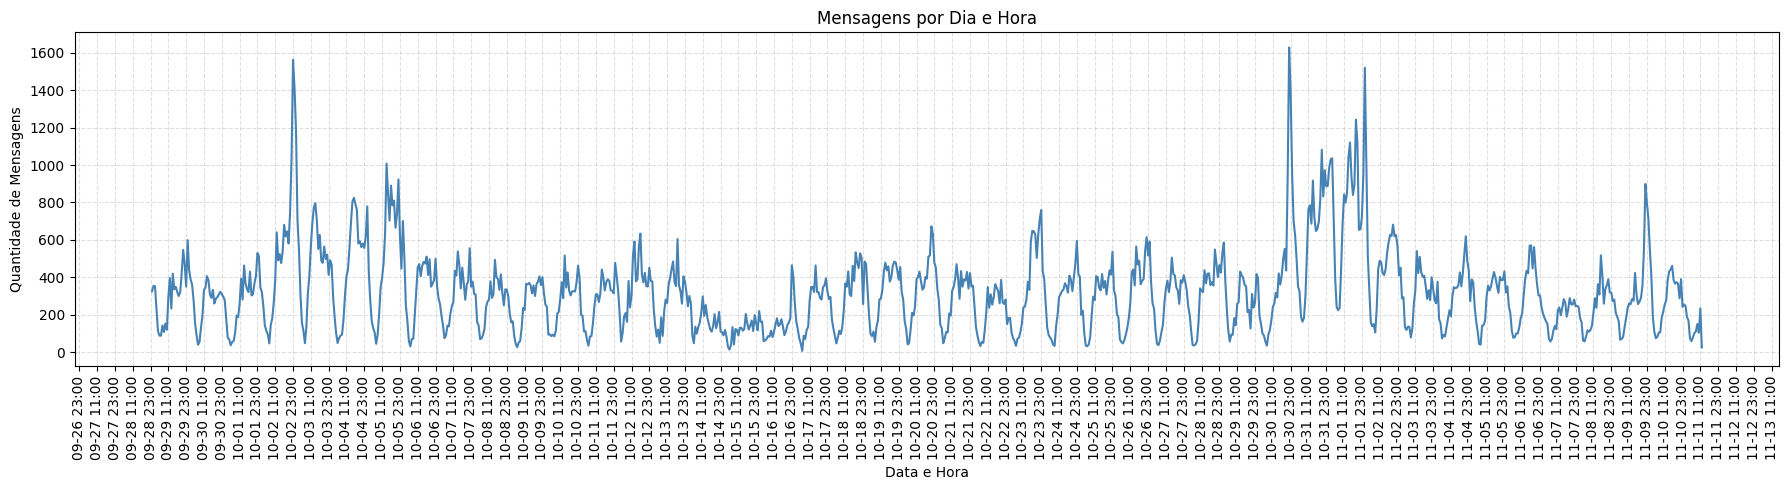

In [74]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(mensagens_por_hora['dia_hora'], mensagens_por_hora['quantidade_mensagens'], color='steelblue')

# R√≥tulos e grade
ax.set_title('Mensagens por Dia e Hora')
ax.set_xlabel('Data e Hora')
ax.set_ylabel('Quantidade de Mensagens')
ax.grid(True, linestyle='--', alpha=0.4)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=12)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

30. Quantidade de mensagens por hora;

In [75]:
df['hora'] = df['date_message'].dt.hour

media_por_hora = (
    df[df['hora'].notna()]
    .groupby('hora')
    .size()
    .reset_index(name='total_mensagens')
)

# Calcular m√©dia por hora (dividindo pelo n√∫mero de dias distintos)
n_dias = df['date_message'].dt.date.nunique()
media_por_hora['media_por_hora'] = media_por_hora['total_mensagens'] / n_dias

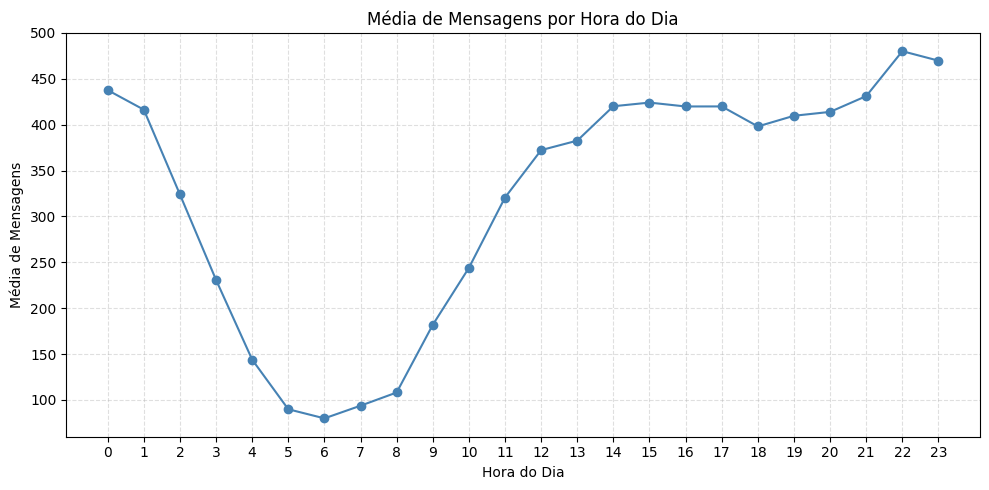

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(media_por_hora['hora'], media_por_hora['media_por_hora'], marker='o', color='steelblue')
plt.xticks(range(0, 24))
plt.title('M√©dia de Mensagens por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('M√©dia de Mensagens')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

31. A nuvem de palavras referente √†s mensagens de texto (ap√≥s a remo√ß√£o de stop words);

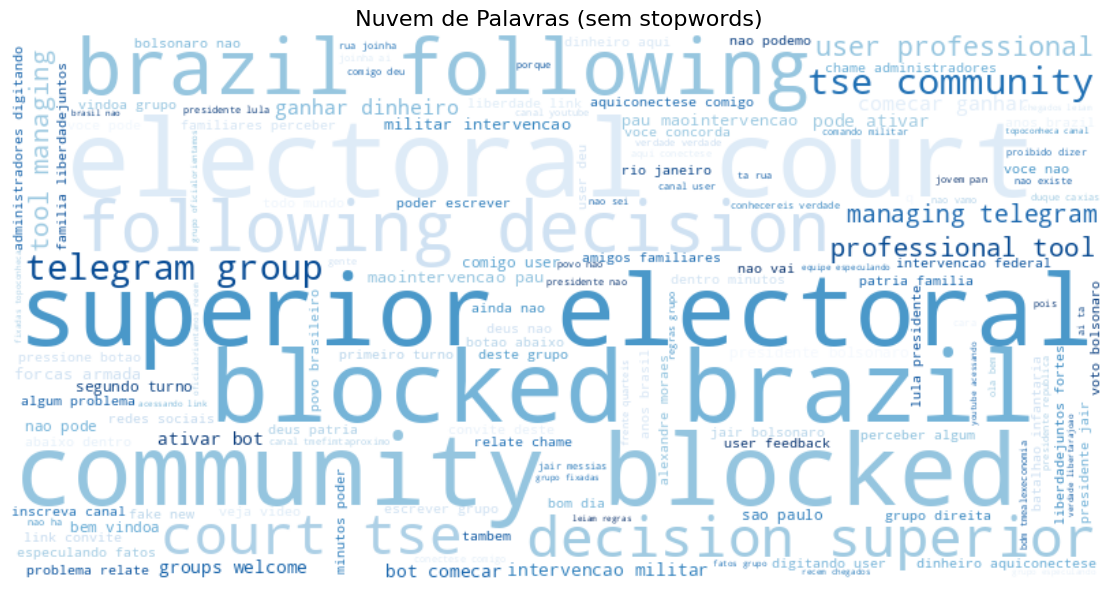

In [ ]:
df_textos = df[df['text_content_anonymous'].notna()].copy()
df_textos['normalized'] = df_textos['text_content_anonymous'].apply(normalize_text)

all_words = []
for linha in df_textos['normalized']:
 
    all_words.exte   tokens = [t for t in linha.split() if t not in stop_words]nd(tokens)

texto_final = ' '.join(all_words)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(texto_final)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' Nuvem de Palavras (sem stopwords)', fontsize=16)
plt.tight_layout()
plt.show()

32. A rede interativa das palavras referente √†s mensagens de texto (ap√≥s a remo√ß√£o de stop words);

In [87]:
df_textos = df[df['text_content_anonymous'].notna()].copy()
df_textos['normalized'] = df_textos['text_content_anonymous'].apply(normalize_text)

# bigramas com stopwords removidas
bigramas = []

for texto in df_textos['normalized']:
    tokens = [t for t in texto.split() if t not in stop_words]
    bigramas.extend(list(ngrams(tokens, 2)))

top_bigramas = Counter(bigramas).most_common(500)  # limite para manter o grafo leve

In [89]:
G = nx.Graph()
for (w1, w2), peso in top_bigramas:
    G.add_edge(w1, w2, weight=peso, value=peso, title=f"{w1} ‚Üî {w2} ({peso})")

net = Network(height="700px", width="1000px", bgcolor="white", font_color="black")
net.from_nx(G)

# ajuste largura das arestas com base no 'value'
for edge in net.edges:
    edge['width'] = edge['value']  # peso visual da conex√£o

# ajuste no tamanho dos n√≥s com base no grau
for node in net.nodes:
    grau = G.degree(node['id'])
    node['size'] = 10 + grau * 2

# repuls√£o
net.repulsion(
    node_distance=200,
    central_gravity=0.1,
    spring_length=150,
    spring_strength=0.05,
    damping=0.09
)

net.write_html("grafo_palavras.html", open_browser=True)


33. Propor√ß√£o de mensagens com e sem URL;

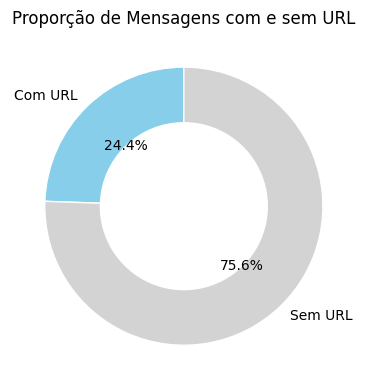

In [92]:
df_filtrado = df[df['text_content_anonymous'].notna()]

contagem = df_filtrado['has_media_url'].value_counts()
labels = ['Com URL', 'Sem URL']
valores = [contagem.get(True, 0), contagem.get(False, 0)]

plt.figure(figsize=(4, 4))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightgray'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Propor√ß√£o de Mensagens com e sem URL')
plt.tight_layout()
plt.show()

34. Propor√ß√£o de desinforma√ß√£o;

In [95]:
df['score_misinformation'].describe()

count    167224.000000
mean          0.312263
std           0.293703
min           0.000003
25%           0.078466
50%           0.197592
75%           0.490396
max           1.000000
Name: score_misinformation, dtype: float64

In [96]:
df_valid = df[df['score_misinformation'].notna()].copy()

def classificar_misinformacao(score):
    if score <= 0.3:
        return 'N√£o Desinforma√ß√£o'
    elif score >= 0.7:
        return 'Desinforma√ß√£o'
    else:
        return 'Neutro'

df_valid['categoria_misinformacao'] = df_valid['score_misinformation'].apply(classificar_misinformacao)

contagem = df_valid['categoria_misinformacao'].value_counts().reindex(['N√£o Desinforma√ß√£o', 'Neutro', 'Desinforma√ß√£o'], fill_value=0)
valores = contagem.values
labels = contagem.index.tolist()

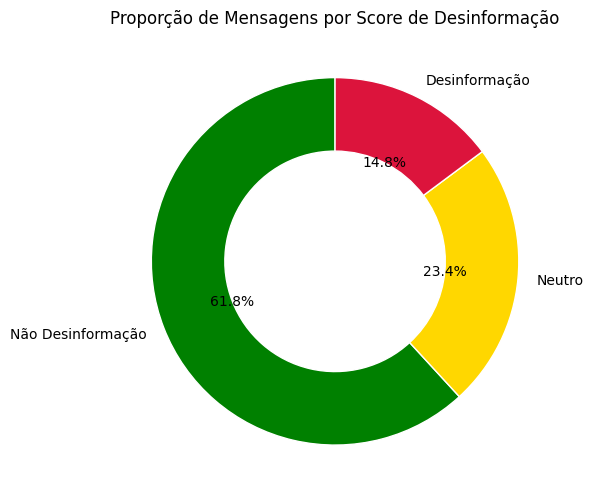

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['green', 'gold', 'crimson'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Propor√ß√£o de Mensagens por Score de Desinforma√ß√£o')
plt.tight_layout()
plt.show()

35. Propor√ß√£o de mensagens contendo m√≠dia e desinforma√ß√£o;

In [109]:
df_desinfo = df[df['score_misinformation'] >= 0.7].copy()

contagem = df_desinfo['has_media'].value_counts()
labels = ['Com M√≠dia', 'Sem M√≠dia']
valores = [contagem.get(True, 0), contagem.get(False, 0)]

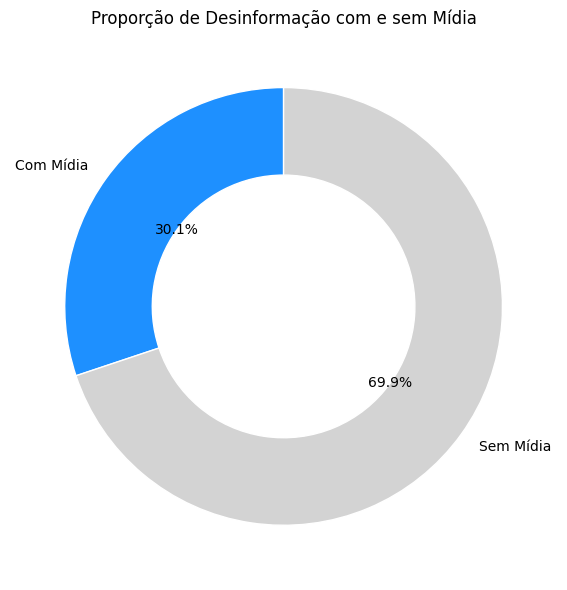

In [111]:
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['dodgerblue', 'lightgray'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Propor√ß√£o de Desinforma√ß√£o com e sem M√≠dia')
plt.tight_layout()
plt.show()

36. Distribui√ß√£o de mensagens por score de desinforma√ß√£o;

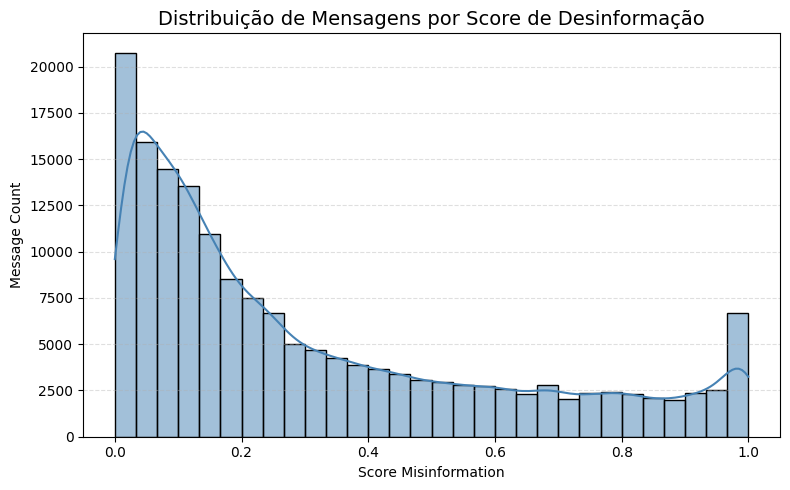

In [114]:
df_valid = df[df['score_misinformation'].notna()].copy()

plt.figure(figsize=(8, 5))
sns.histplot(df_valid['score_misinformation'], bins=30, kde=True, color='steelblue')

plt.title('Distribui√ß√£o de Mensagens por Score de Desinforma√ß√£o', fontsize=14)
plt.xlabel('Score Misinformation')
plt.ylabel('Message Count')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

37. Propor√ß√£o de sentimentos;

In [117]:
df['score_sentiment'].describe()

count    339239.000000
mean          0.022025
std           0.529724
min          -1.000000
25%          -0.381800
50%           0.000000
75%           0.505300
max           0.999200
Name: score_sentiment, dtype: float64

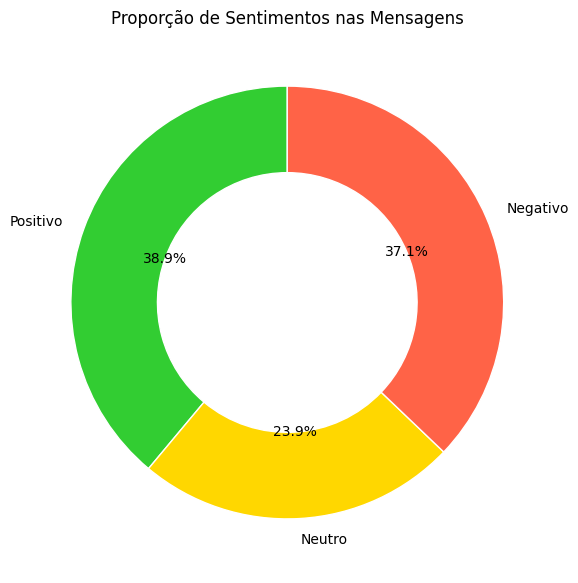

In [ ]:
df_sent = df[df['score_sentiment'].notna()].copy()

def classificar_sentimento(score):
    if score <= -0.05:
        return 'Negativo'
    elif score >= 0.05:
        return 'Positivo'
    else:
        return 'Neutro'

df_sent['categoria_sentimento'] = df_sent['score_sentiment'].apply(classificar_sentimento)

contagem = df_sent['categoria_sentimento'].value_counts().reindex(['Positivo', 'Neutro', 'Negativo'], fill_value=0)
labels = contagem.index
valores = contagem.values

plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['limegreen', 'gold', 'tomato'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Propor√ß√£o de Sentimentos nas Mensagens')
plt.tight_layout()
plt.show()

38. Distribui√ß√£o de mensagens por score de sentimentos;

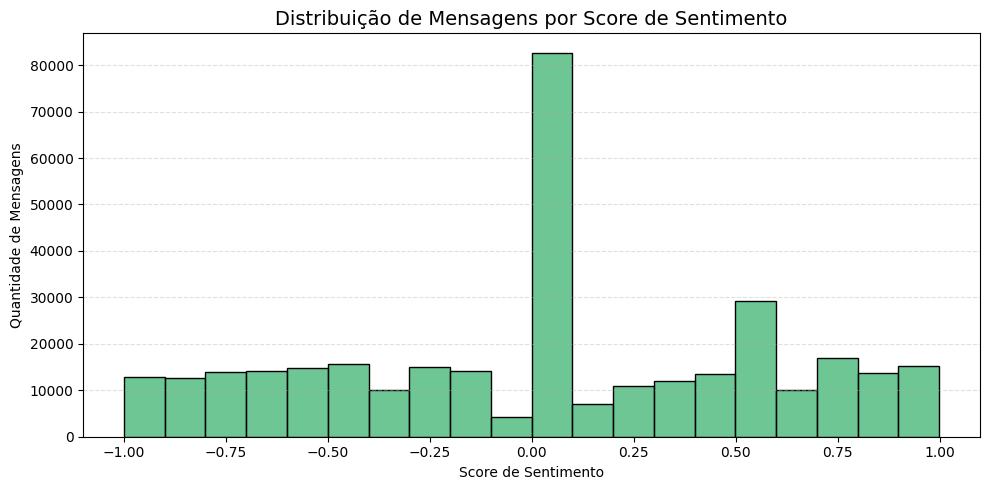

In [121]:
df_valid = df[df['score_sentiment'].notna()].copy()

plt.figure(figsize=(10, 5))
sns.histplot(df_valid['score_sentiment'], bins=20, kde=False, color='mediumseagreen')

plt.title('Distribui√ß√£o de Mensagens por Score de Sentimento', fontsize=14)
plt.xlabel('Score de Sentimento')
plt.ylabel('Quantidade de Mensagens')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

39. Propor√ß√£o entre mensagens virais e n√£o virais;

In [127]:
df['normalized_text'] = df['text_content_anonymous'].apply(normalize_text)
df['viral'] = df.duplicated(subset='normalized_text', keep=False).astype(int)

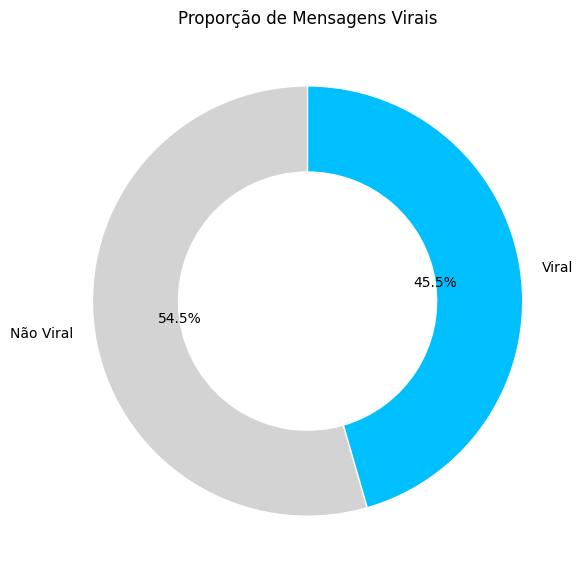

In [129]:
# Contar virais vs n√£o virais
contagem = df['viral'].value_counts().rename(index={0: 'N√£o Viral', 1: 'Viral'})
labels = contagem.index
valores = contagem.values

# Gr√°fico
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgray', 'deepskyblue'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Propor√ß√£o de Mensagens Virais')
plt.tight_layout()
plt.show()


40. Algo que voc√™ julga importante e que ainda n√£o foi solicitado;

In [134]:
df_links = df[df['id_member_anonymous'].notna()][['id_member_anonymous', 'id_group_anonymous']].drop_duplicates()

# Contar quantos grupos cada usu√°rio est√°
usuarios_multigrupo = df['id_member_anonymous'].value_counts()
usuarios_validos = usuarios_multigrupo[usuarios_multigrupo >= 2].index

# Contar quantos usu√°rios cada grupo tem
grupos_comuns = df['id_group_anonymous'].value_counts()
grupos_validos = grupos_comuns[grupos_comuns <= 100].index

# Filtrar
df_links = df[
    df['id_member_anonymous'].isin(usuarios_validos) &
    df['id_group_anonymous'].isin(grupos_validos)
][['id_member_anonymous', 'id_group_anonymous']].drop_duplicates()


In [ ]:
G = nx.Graph()

# Adicionar n√≥s com tipo
usuarios = df_links['id_member_anonymous'].unique()
grupos = df_links['id_group_anonymous'].unique()

G.add_nodes_from(usuarios, tipo='usuario')
G.add_nodes_from(grupos, tipo='grupo')

# Adicionar arestas (usu√°rio ‚Üí grupo)
for _, row in df_links.iterrows():
    G.add_edge(row['id_member_anonymous'], row['id_group_anonymous'])

# Criar rede interativa com pyvis
net = Network(height="800px", width="100%", bgcolor="white", font_color="black", notebook=False)
net.from_nx(G)

# Estilizar n√≥s
for node in net.nodes:
    tipo = G.nodes[node['id']].get('tipo')
    if tipo == 'usuario':
        node['color'] = 'lightblue'
        node['shape'] = 'dot'
        node['size'] = 10
    elif tipo == 'grupo':
        node['color'] = 'lightgreen'
        node['shape'] = 'triangle'
        node['size'] = 20

net.repulsion(node_distance=180, spring_length=100)

net.write_html("grafo_usuarios_grupos.html", open_browser=True)

In [138]:
df.to_csv('data_results/df_final_lista-3.csv')